# Import 

In [51]:
import subprocess
import os
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def importPDB(path_to_file,atom_type='',chain_name='',data_type=None):
    if data_type not in ['atom','seq']:
        print("Must provide value for data_type. Please enter either 'atom' or 'seq'.")
    else:
        if data_type == 'atom':
            #print('atom selected')
            try:
                with open(path_to_file, 'r') as pdbFile:
                    pdb = [line.split()[6:9] for line in pdbFile if re.match('ATOM(.*?)'+atom_type+'(.*?)\s'+chain_name+'\s',line)]
                return np.array(pdb,dtype=float).transpose()
                print('.pdb imported')
            except:
                print('Import error, please check path')
        else:
            #print('sequence selected')
            try:
                with open(path_to_file, 'r') as pdbFile:
                    pdb = [line.split()[3] for line in pdbFile if re.match('ATOM(.*?)CA(.*?)\s'+chain_name+'\s',line)]
                return pdb
                print('.pdb imported')
            except:
                print('Import error, please check path')

# Practice

In [32]:
#given some pdb
file_path = "/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts"
protein = "/99/4/3D9T_B_D_99_1"
total_conts_path = file_path + protein + "/" + "prot.conts"
total_pdb_path = file_path + protein + "/" + "prot.pdb"
minor_chain = "B"

with open(total_conts_path,"r") as contact_f:
    contact_list = [str.split(line) for line in contact_f if len(re.findall(minor_chain+",",line)) == 1]

contact_df = pd.DataFrame(contact_list,columns=["contact type","main_chain_pos","RES","minor_chain_pos","RES","CD"])
print(contact_df)

#find the chain length
chain_length = len(importPDB(total_pdb_path,chain_name='B',data_type='seq'))
print('chain length',chain_length)

#find the list of all residues with contacts
res_with_conts = list(set([int(x[2:]) for x in contact_df.iloc[:,3].tolist()]))
print('residues with contacts',res_with_conts)

res_count = 0
flanking_list = list()
for i in range(3,chain_length-1):
    if i in res_with_conts:
        res_count += 1
        for j in range(i-2,i+3):
            flanking_list.append(j)
print(flanking_list)    
flanking_list = list(set(flanking_list))
print('TERM coverage',res_count/(chain_length-4))
print('TERM flanking coverage',len(flanking_list)/(chain_length))
print('contact coverage',len(res_with_conts)/chain_length)
#will add to dictionary

   contact type main_chain_pos  RES minor_chain_pos  RES         CD
0            ss           B,28  VAL             D,1  ALA  0.0720041
1            ss           B,46  ASP             D,4  PHE    0.26955
2            ss           B,54  GLY             D,3  PRO    0.14789
3            ss           B,55  GLY             D,4  PHE   0.261161
4            ss           B,56  LEU             D,1  ALA   0.394913
5            ss           B,56  LEU             D,3  PRO  0.0775154
6            ss           B,57  ARG             D,2  THR  0.0761681
7            ss           B,57  ARG             D,4  PHE   0.457751
8            ss           B,58  CYS             D,2  THR   0.160506
9            ss           B,59  TRP             D,1  ALA    0.38115
10           ss           B,63  ASP             D,1  ALA   0.226159
11           ss           B,68  GLU             D,1  ALA   0.370521
12           ss           B,72  TRP             D,3  PRO   0.375066
13           ss           B,73  PHE             

# Analysis of subcluster contacts (ss)

## Making a table of TERM coverage

In [196]:
subclus_conts_path = "/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts"
all_proteins_path = "/*/*/*/prot.conts"

call = "find " + subclus_conts_path+all_proteins_path
all_protein_conts = subprocess.check_output(call,shell=True)
all_protein_conts = str.split(all_protein_conts.rstrip().decode('utf-8'),'\n')

TERM_coverage = list()

for protein in all_protein_conts:
    
    print(protein)
    minor_chain = protein.split('/')[-2].split('_')[-3]
    
    with open(protein,"r") as contact_f:
        contact_list = [str.split(line) for line in contact_f if len(re.findall(minor_chain+",",line)) == 1]

        contact_df = pd.DataFrame(contact_list,columns=["contact type","main_chain_pos","RES","minor_chain_pos","RES","CD"])
        #print(contact_df)

        #find the chain length
        chain_length = len(importPDB(protein[:-5]+'pdb',chain_name=minor_chain,data_type='seq'))
        #print(chain_length)

        #find the list of residues with contacts
        res_with_conts = list(set([int(x[2:]) for x in contact_df.iloc[:,3].tolist()]))
        
        res_count = 0
        flanking_list = list()
        for i in range(3,chain_length-1):
            if i in res_with_conts:
                res_count += 1
                for j in range(i-2,i+3):
                    flanking_list.append(j)
        print(flanking_list)    
        flanking_list = list(set(flanking_list))
        print('TERM coverage',res_count/(chain_length-4))
        print('TERM flanking coverage',len(flanking_list)/chain_length)
        print('contact coverage',len(res_with_conts)/chain_length)
        #will add to dictionary
            
        TERM_coverage.append([protein.split('/')[-2],chain_length,res_count/(chain_length-4),len(flanking_list)/chain_length,len(res_with_conts)/chain_length])

TERM_coverage_df = pd.DataFrame(TERM_coverage,columns=["complex","chain length","TERM coverage","TERM coverage (flanking)","Contact coverage"])
TERM_coverage_df

/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/100/1/1OU8_A_C_100_1/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11]
TERM coverage 0.8571428571428571
TERM flanking coverage 0.9090909090909091
contact coverage 0.7272727272727273
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/100/1/1TWB_A_C_100_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7]
TERM coverage 0.75
TERM flanking coverage 0.875
contact coverage 0.875
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/100/2/1YFN_C_G_100_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15]
TERM coverage 0.7272727272727273
TERM flanking coverage 1.0
contact coverage 0.7333333333333333
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/101/1/4IKN_A_B_101_3/prot.conts
[]
TERM coverage 0.0
T

[3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 12, 13, 14, 15, 16]
TERM coverage 0.6666666666666666
TERM flanking coverage 0.875
contact coverage 0.625
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/106/1/4YFA_F_E_106_1/prot.conts
[1, 2, 3, 4, 5, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15]
TERM coverage 0.7272727272727273
TERM flanking coverage 1.0
contact coverage 0.6666666666666666
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/106/1/4YFB_F_E_106_1/prot.conts
[3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14]
TERM coverage 0.6
TERM flanking coverage 0.8571428571428571
contact coverage 0.6428571428571429
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/107/1/1CSB_E_D_107_1/prot.conts
[1, 2, 3, 4, 5, 2, 3,

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/10/3VXP_D_F_1_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/10/3WL9_A_C_1_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/10/3WLB_A_C_1_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10]
TERM coverage 0.8333333333333334
TERM flanking coverage 1.0
contact coverage 0.9
/scratch/users/swans/decorate_PixelDB_project/subclusters_f

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/11/1/4Y7R_A_B_11_3/prot.conts
[1, 2, 3, 4, 5, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8]
TERM coverage 0.75
TERM flanking coverage 1.0
contact coverage 0.625
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/1/1DUY_D_F_1_5/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/1/1EEY_D_F_1_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/1/1EEZ_D_F_1_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.6666666666666666
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/11/2/4J78_A_B_11_2/prot.conts
[1, 2, 3, 4, 5]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/11/2/4J79_A_B_11_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.6666666666666666
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/11/2/4J81_B_C_11_2/prot.conts
[1, 2, 3, 4, 5]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/11/2/4J82_B_D_11_2/prot.conts
[1, 2, 3, 4, 5]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/11/2/4J84_A_C_11_10/prot.conts
[1, 2, 3,

[1, 2, 3, 4, 5, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 0.8
TERM flanking coverage 1.0
contact coverage 0.8888888888888888
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/1/3GSX_A_P_1_1/prot.conts
[1, 2, 3, 4, 5, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 0.8
TERM flanking coverage 1.0
contact coverage 0.8888888888888888
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/1/3H9H_D_F_1_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/1/3HPJ_D_F_1_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 0.8
TERM flanking coverage 1.0
contact coverage 0.8888888888888888
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/1/3I6G_D_F_1_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4,

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 11, 12, 13, 14, 15]
TERM coverage 0.8181818181818182
TERM flanking coverage 1.0
contact coverage 0.8
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/114/1/5AJO_A_B_114_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 11, 12, 13, 14, 15]
TERM coverage 0.8181818181818182
TERM flanking coverage 1.0
contact coverage 0.8
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/114/1/5AJP_A_B_114_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 10, 11, 12, 13, 14]
TERM coverage 0.7
TERM flanking coverage 1.0
contact coverage 0.6428571428571429
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/14/1VGK_A_C_1_3/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/116/1/3NJF_C_D_116_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/116/1/3NJN_C_D_116_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/16/1BII_A_P_1_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/116/2/3NJI_A_B_116_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7]
TERM cove

[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 13, 14, 15, 16, 17, 14, 15, 16, 17, 18, 15, 16, 17, 18, 19]
TERM coverage 0.8125
TERM flanking coverage 0.9
contact coverage 0.8
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/119/1/4ZII_A_C_119_1/prot.conts
[2, 3, 4, 5, 6, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 12, 13, 14, 15, 16, 13, 14, 15, 16, 17, 14, 15, 16, 17, 18, 16, 17, 18, 19, 20, 17, 18, 19, 20, 21, 18, 19, 20, 21, 22, 20, 21, 22, 23, 24]
TERM coverage 0.75
TERM flanking coverage 0.9583333333333334
contact coverage 0.6666666666666666
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/19/3BXN_A_C_1_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 1.0
TERM flanking cover

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 12, 13, 14, 15, 16, 13, 14, 15, 16, 17]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/21/3BZE_G_S_1_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/21/3BZF_C_Q_1_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/12/1/3GOF_B_D_12_3/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9,

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/2/2FZ3_A_C_1_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 7, 8, 9, 10, 11]
TERM coverage 0.7142857142857143
TERM flanking coverage 1.0
contact coverage 0.8181818181818182
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/2/2H6P_A_C_1_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/2/2NW3_A_C_1_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13]
TERM coverage 0.6666666666666666
TERM flanking coverage 1.0
contact coverage 0.7692307692307693
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/2/3VFW_A_C_1_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13]
TERM coverage 0.6666666666666666
TERM flanking coverage 1.0
contact coverage 0.7692307692307693
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/124/1/4XO9_A_B_124_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/124/1/4XOE_A_B_124_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 0.8
TERM flanking coverage 1.0
contact coverage 0.8888888888888888
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/127/1/2H1P_LH_P_127_3/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11]
TERM coverage 0.8571428571428571
TERM flanking coverage 1.0
contact coverage 0.9090909090909091
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/127/2/3MLX_IM_Q_127_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14]
TERM coverage 0.9
TERM flanking coverage 1.0
contact coverage 0.8571428571428571
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/127/3/4GW5_CD_F_127_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/3/1JUF_A_C_1_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/3/1S7U_J_L_1_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/3/1S7V_D_F_1_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/3/1S7W_J_L_1_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4,

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/3/3TBT_J_L_1_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/3/3TBV_G_L_1_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/3/3TBW_G_L_1_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/3/3WS3_C_F_1_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4,

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.9285714285714286
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/140/1/2QYF_A_E_140_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10]
TERM coverage 0.8571428571428571
TERM flanking coverage 0.9090909090909091
contact coverage 0.8181818181818182
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/140/2/4EXT_C_B_140_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 12, 13, 14, 15, 16, 13, 14, 15, 16, 17, 14, 15, 16, 17, 18, 16, 17, 18, 19, 20]
TERM coverage 0.7368421052631579
TERM flanking coverage 0.8695652173913043
contact coverage

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15]
TERM coverage 0.9090909090909091
TERM flanking coverage 1.0
contact coverage 0.8
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/14/2/4JMY_B_F_14_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/4/2CLV_A_C_1_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/4/2CLZ_A_C_1_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/143/1/2DEW_X_A_

[3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10]
TERM coverage 0.6666666666666666
TERM flanking coverage 0.8
contact coverage 0.7
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/145/1/4WVJ_A_D_145_1/prot.conts
[3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13]
TERM coverage 0.7777777777777778
TERM flanking coverage 0.8461538461538461
contact coverage 0.7692307692307693
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/14/5/1JXP_B_D_14_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.9166666666666666
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/146/1/3SHB_A_B_146_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverag

[2, 3, 4, 5, 6, 4, 5, 6, 7, 8]
TERM coverage 0.5
TERM flanking coverage 0.875
contact coverage 0.625
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/15/2/2OKR_D_F_15_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 7, 8, 9, 10, 11, 9, 10, 11, 12, 13, 11, 12, 13, 14, 15, 12, 13, 14, 15, 16, 14, 15, 16, 17, 18, 15, 16, 17, 18, 19, 18, 19, 20, 21, 22]
TERM coverage 0.55
TERM flanking coverage 0.9166666666666666
contact coverage 0.5416666666666666
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/15/2/2Y8O_A_B_15_1/prot.conts
[2, 3, 4, 5, 6, 4, 5, 6, 7, 8]
TERM coverage 0.5
TERM flanking coverage 0.875
contact coverage 0.75
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/15/2/3P4K_A_P_15_1/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 6, 7, 8, 9, 10]
TERM coverage 0.5714285714285714
TERM flanking coverage 0.8181818181818182
contact coverage 0.6363636363636364
/scratch/users/swans

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 5, 6, 7, 8, 9]
TERM coverage 0.6
TERM flanking coverage 1.0
contact coverage 0.4444444444444444
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/15/5/4H3B_C_D_15_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 5, 6, 7, 8, 9]
TERM coverage 0.5
TERM flanking coverage 0.9
contact coverage 0.4
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/156/1/1YTV_A_M_156_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8333333333333334
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/156/1/1YTV_B_N_156_1/prot.conts
[1, 2, 3, 4, 5]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/15/6/1UKH_A_B_15_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 5, 6, 7, 8, 9]
TERM coverage 0.5
TERM flanking coverage 0.9
contact coverage 0.5
/scratch/users/swans/decorate_Pixel

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/16/1/4JWC_A_C_16_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8888888888888888
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/16/1/4JWD_B_C_16_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/16/1/4JWE_A_D_16_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.7777777777777778
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/16/1/4JWI_A_C_16_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 

[1, 2, 3, 4, 5, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 12, 13, 14, 15, 16, 15, 16, 17, 18, 19, 16, 17, 18, 19, 20]
TERM coverage 0.7222222222222222
TERM flanking coverage 0.9090909090909091
contact coverage 0.6363636363636364
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/166/1/4YZ6_A_B_166_1/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 14, 15, 16, 17, 18]
TERM coverage 0.7142857142857143
TERM flanking coverage 0.9444444444444444
contact coverage 0.6111111111111112
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/167/1/1TMC_A_C_167_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 6, 7, 8, 9, 10]
TERM coverage 0.8333333333333334
TERM flanking coverage 1.0
contact coverage 0.9
/

[1, 2, 3, 4, 5, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 0.8
TERM flanking coverage 1.0
contact coverage 0.8888888888888888
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/7/3L3G_A_C_1_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/7/3L3I_A_C_1_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/7/3L3J_A_C_1_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/174/1/3IUR_A_B_174_2/prot.conts
[1, 2, 3, 4, 5]
TERM

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6]
TERM coverage 0.6666666666666666
TERM flanking coverage 0.8571428571428571
contact coverage 0.7142857142857143
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/18/2/3ET3_A_P_18_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 6, 7, 8, 9, 10, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 12, 13, 14, 15, 16]
TERM coverage 0.6666666666666666
TERM flanking coverage 1.0
contact coverage 0.5625
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/18/2/3G9E_A_B_18_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10]
TERM coverage 0.8333333333333334
TERM flanking coverage 1.0
contact coverage 0.7
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/18/2/3T03_B_D_18_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 9, 10, 11, 12, 13]
TERM coverage 0.6666666666666666
TERM flanking coverage 1.0
contact c

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.9333333333333333
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/189/1/2R28_BA_D_189_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 12, 13, 14, 15, 16, 13, 14, 15, 16, 17, 14, 15, 16, 17, 18, 15, 16, 17, 18, 19]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8947368421052632
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/189/1/2W73_AB_K_189_1/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 1

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11]
TERM coverage 0.7142857142857143
TERM flanking coverage 1.0
contact coverage 0.8181818181818182
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/9/2YPK_A_C_1_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11]
TERM coverage 0.7142857142857143
TERM flanking coverage 1.0
contact coverage 0.8181818181818182
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/193/1/4Z80_A_C_193_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 14, 15, 16, 17, 18, 15, 16, 17, 18, 19, 16, 17, 18, 19, 20, 17, 18, 19, 20, 21, 18, 19, 20, 21, 22, 20, 21, 22, 23, 24, 22, 23, 24, 25, 26, 24, 25, 26, 27, 28, 25, 26, 27, 28, 29, 27, 28, 29, 30, 31, 28, 29, 30, 31, 32]
TERM coverage 0.75
TERM flanking coverage 1.0
contac

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/9/4WU5_D_F_1_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/1/9/4WU7_D_F_1_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/195/1/4U7Y_A_B_195_1/prot.conts
[3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11]
TERM coverage 0.4444444444444444
TERM flanking coverage 0.6923076923076923
contact coverage 0.5384615384615384
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/195/2/2W2U_A_C_195_2/prot.conts
[1, 2, 3, 4, 5, 5, 6, 7, 8, 

[1, 2, 3, 4, 5]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/20/1/4JOH_B_C_20_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8571428571428571
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/20/1/4JOP_B_D_20_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8571428571428571
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/20/1/4JOR_B_D_20_2/prot.conts
[1, 2, 3, 4, 5]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/20/1/4K72_B_D_20_1/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 0.8
TERM flanking coverage 0.8888888888888888
contact coverage 0.6666666666666666
/scratch/

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/20/8/4GVD_B_C_20_3/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.875
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/209/1/4UQY_A_B_209_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 6, 7, 8, 9, 10, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13]
TERM coverage 0.6666666666666666
TERM flanking coverage 1.0
contact coverage 0.6153846153846154
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/209/1/4UQZ_A_B_209_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 6, 7, 8, 9, 10, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 11, 12, 13, 14, 15, 12, 13, 14, 15, 16, 13, 14, 15, 16, 17, 14, 15, 16, 17, 18, 15, 16, 17, 18, 19, 16, 17, 18, 19, 20,

[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 0.8
TERM flanking coverage 0.8888888888888888
contact coverage 0.7777777777777778
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/2/12/1YUC_B_D_2_1/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11]
TERM coverage 0.7142857142857143
TERM flanking coverage 0.9090909090909091
contact coverage 0.7272727272727273
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/2/12/3BQD_A_B_2_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11]
TERM coverage 0.8571428571428571
TERM flanking coverage 1.0
contact coverage 0.6363636363636364
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/2/12/4ONI_B_D_2_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10]
TERM coverage 0.8333333333333334
TERM flanking coverage 1.0
contact coverage 

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 5, 6, 7, 8, 9]
TERM coverage 0.8
TERM flanking coverage 1.0
contact coverage 0.7777777777777778
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/2/15/3OMQ_B_D_2_1/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 6, 7, 8, 9, 10]
TERM coverage 0.6666666666666666
TERM flanking coverage 0.9
contact coverage 0.7
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/2/15/4J24_D_L_2_1/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 6, 7, 8, 9, 10]
TERM coverage 0.6666666666666666
TERM flanking coverage 0.9
contact coverage 0.7
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/216/1/3V43_A_Q_216_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8571428571428571
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/2/16/1ZDT_B_Q_2_1/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7,

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8]
TERM coverage 0.8
TERM flanking coverage 0.8888888888888888
contact coverage 0.8888888888888888
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/22/2/1BQP_C_D_22_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 13, 14, 15, 16, 17, 14, 15, 16, 17, 18, 15, 16, 17, 18, 19, 16, 17, 18, 19, 20, 17, 18, 19, 20, 21, 18, 19, 20, 21, 22, 19, 20, 21, 22, 23, 20, 21, 22, 23, 24, 21, 22, 23, 24, 25, 22, 23, 24, 25, 26, 23, 24, 25, 26, 27, 24, 25, 26, 27, 28, 25, 26, 27, 28, 29, 26, 27, 28, 29, 30, 27, 28, 29, 30, 31, 28, 29, 30, 31, 32, 29, 30, 31, 32, 33, 30, 31, 32, 33, 34, 31, 32, 33, 34, 35, 32, 33, 34, 35, 36, 33, 34, 35, 36, 37, 34, 35, 36, 37, 38, 35, 36, 37, 38, 39, 36, 37, 38, 39, 40, 37, 38, 39, 40, 41, 38, 39, 40, 41, 42, 39, 40, 41, 42, 43, 40, 41, 42, 4

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 13, 14, 15, 16, 17, 14, 15, 16, 17, 18, 15, 16, 17, 18, 19, 16, 17, 18, 19, 20, 17, 18, 19, 20, 21, 18, 19, 20, 21, 22, 19, 20, 21, 22, 23, 20, 21, 22, 23, 24, 21, 22, 23, 24, 25, 22, 23, 24, 25, 26, 23, 24, 25, 26, 27, 24, 25, 26, 27, 28, 25, 26, 27, 28, 29, 26, 27, 28, 29, 30, 27, 28, 29, 30, 31, 28, 29, 30, 31, 32, 29, 30, 31, 32, 33, 30, 31, 32, 33, 34, 31, 32, 33, 34, 35, 32, 33, 34, 35, 36, 33, 34, 35, 36, 37, 34, 35, 36, 37, 38, 35, 36, 37, 38, 39, 36, 37, 38, 39, 40, 37, 38, 39, 40, 41, 38, 39, 40, 41, 42, 39, 40, 41, 42, 43, 40, 41, 42, 43, 44, 41, 42, 43, 44, 45, 42, 43, 44, 45, 46, 43, 44, 45, 46, 47]
TERM coverage 0.9767441860465116
TERM flanking coverage 1.0
contact coverage 0.9574468085106383
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/2/23/4UDA_A_B_2_1/prot.c

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/23/1/4PRH_AED_C_23_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/23/1/4PRP_AED_C_23_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/232/1/4DS7_AB_F_232_1/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 1

TERM flanking coverage 1.0
contact coverage 0.75
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/24/1/3AVB_AB_Y_24_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.75
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/24/1/3AVC_AB_F_24_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.75
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/24/1/3AVF_BA_F_24_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.75
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/24/1/3AVG_AB_F_24_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.75
/scratch/users/swan

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 4, 5, 6, 7, 8, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12]
TERM coverage 0.75
TERM flanking coverage 1.0
contact coverage 0.6666666666666666
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/252/1/1R2B_AB_D_252_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 12, 13, 14, 15, 16, 13, 14, 15, 16, 17]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8823529411764706
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/25/2/3HXG_A_C_25_1/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 11, 12, 13, 14, 15]
TERM coverage 0.7272727272727273
TERM flanking coverage 0.9333333333333333
contact coverage 0.7333333333333333
/scratch/users/swans/decorate_PixelDB_project/subclusters

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/26/1/4CC2_C_D_26_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10]
TERM coverage 0.8333333333333334
TERM flanking coverage 1.0
contact coverage 0.8
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/26/1/4CC3_G_H_26_2/prot.conts
[1, 2, 3, 4, 5, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12]
TERM coverage 0.625
TERM flanking coverage 1.0
contact coverage 0.6666666666666666
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/262/1/3ZQI_AB_C_262_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14]
TERM coverage 0.9
TERM flanking coverage 1.0
contact coverage 0.8571428571428571
/scratch/users/swan

[3, 4, 5, 6, 7, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 13, 14, 15, 16, 17]
TERM coverage 0.46153846153846156
TERM flanking coverage 0.8823529411764706
contact coverage 0.47058823529411764
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/27/12/4JZO_GH_L_27_7/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11]
TERM coverage 0.8571428571428571
TERM flanking coverage 1.0
contact coverage 0.7272727272727273
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/27/1/3DRQ_AB_C_27_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.75
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/27/1/3IDI_AB_C_27_1/prot.conts
[1, 2, 3, 4, 5]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8
/scratch/users/swans/decorate_PixelDB_project/subclusters_frag

[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 11, 12, 13, 14, 15]
TERM coverage 0.6363636363636364
TERM flanking coverage 0.9333333333333333
contact coverage 0.6
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/28/3/3V2O_A_B_28_2/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11]
TERM coverage 0.7142857142857143
TERM flanking coverage 0.9090909090909091
contact coverage 0.7272727272727273
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/28/3/4LG6_A_B_28_2/prot.conts
[1, 2, 3, 4, 5, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11]
TERM coverage 0.625
TERM flanking coverage 0.9166666666666666
contact coverage 0.5833333333333334
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/2/8/3FS1_A_B_2_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 0.8
TERM flanking coverage 1.0
con

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15]
TERM coverage 0.9166666666666666
TERM flanking coverage 0.9375
contact coverage 0.9375
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/30/1/2BYP_BA_G_30_1/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11]
TERM coverage 0.8571428571428571
TERM flanking coverage 0.9090909090909091
contact coverage 0.9090909090909091
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/30/1/2UZ6_FG_P_30_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15]
TERM coverage 0.9166666666666666
TERM flanking coverage 0.9375
contact coverage 0.9375
/scratch/users/swans/decorate_PixelDB_p

[1, 2, 3, 4, 5, 3, 4, 5, 6, 7]
TERM coverage 0.3333333333333333
TERM flanking coverage 0.7
contact coverage 0.6
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/3/1/1LHG_H_I_3_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6]
TERM coverage 0.6666666666666666
TERM flanking coverage 0.8571428571428571
contact coverage 0.7142857142857143
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/3/1/1NRR_H_R_3_8/prot.conts
[1, 2, 3, 4, 5]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/3/1/1OYT_H_I_3_2/prot.conts
[]
TERM coverage 0.0
TERM flanking coverage 0.0
contact coverage 0.6
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/3/1/1QUR_H_I_3_8/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 9, 10, 11, 12, 13]
TERM coverage 0.5454545454545454
TERM flanking coverage 0.8
contact coverage 0.5333333333

[1, 2, 3, 4, 5, 3, 4, 5, 6, 7]
TERM coverage 0.3333333333333333
TERM flanking coverage 0.7
contact coverage 0.6
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/3/1/4BAH_B_A_3_3/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 16, 17, 18, 19, 20, 17, 18, 19, 20, 21, 18, 19, 20, 21, 22, 20, 21, 22, 23, 24, 21, 22, 23, 24, 25, 22, 23, 24, 25, 26, 24, 25, 26, 27, 28, 25, 26, 27, 28, 29]
TERM coverage 0.68
TERM flanking coverage 0.9310344827586207
contact coverage 0.6206896551724138
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/3/1/4BAO_B_A_3_3/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 15, 16, 17, 18, 19, 16, 17, 18, 19, 20, 17, 18, 19, 20, 21, 19, 20, 21, 22, 23, 20, 21, 22, 23, 24, 21, 22, 23, 24, 25, 23, 24, 2

[2, 3, 4, 5, 6, 3, 4, 5, 6, 7]
TERM coverage 0.5
TERM flanking coverage 0.75
contact coverage 0.625
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/3/2/1O3P_B_A_3_6/prot.conts
[1, 2, 3, 4, 5, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8]
TERM coverage 0.75
TERM flanking coverage 1.0
contact coverage 0.375
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/3/2/1OX1_A_B_3_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 6, 7, 8, 9, 10]
TERM coverage 0.8333333333333334
TERM flanking coverage 1.0
contact coverage 0.6
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/3/2/1PPE_E_I_3_1/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 23, 24, 25, 26, 27, 25, 26, 27, 28, 29]
TERM coverage 0.4
TERM flanking coverage 0.8620689655172413
contact coverage 0.41379310344827586
/scratch/users/swans/decorate_PixelDB_project/

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12]
TERM coverage 0.7777777777777778
TERM flanking coverage 0.9230769230769231
contact coverage 0.7692307692307693
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/3/2/4ZHL_U_P_3_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/3/2/4ZKS_U_P_3_5/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12]
TERM coverage 0.75
TERM flanking coverage 0.9166666666666666
contact coverage 0.5
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/325/1/3MHP_AB_C_325_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 

[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 23, 24, 25, 26, 27, 25, 26, 27, 28, 29]
TERM coverage 0.4
TERM flanking coverage 0.8620689655172413
contact coverage 0.41379310344827586
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/3/3/2NWN_A_B_3_5/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12]
TERM coverage 0.875
TERM flanking coverage 1.0
contact coverage 0.5833333333333334
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/3/3/2O9Q_A_C_3_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 10, 11, 12, 13, 14]
TERM coverage 0.8
TERM flanking coverage 1.0
contact coverage 0.7857142857142857
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/333/1/3QLC_B_D_333_1/prot.conts
[1, 2, 3

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8333333333333334
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/34/1/1KZO_BA_C_34_4/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/34/1/1KZP_BA_C_34_1/prot.conts
[1, 2, 3, 4, 5]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/34/1/1TN6_BA_C_34_3/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11]
TERM coverage 0.8571428571428571
TERM flanking coverage 1.0
contact coverage 0.9090909090909091
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/34/1/1TN7_BA_C_34_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/s

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 11, 12, 13, 14, 15, 13, 14, 15, 16, 17, 14, 15, 16, 17, 18]
TERM coverage 0.625
TERM flanking coverage 0.9
contact coverage 0.65
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/351/1/3OWT_AB_C_351_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 13, 14, 15, 16, 17, 15, 16, 17, 18, 19, 16, 17, 18, 19, 20]
TERM coverage 0.6875
TERM flanking coverage 1.0
contact coverage 0.75
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/35/1/1ELR_A_B_35_1/prot.conts
[]
TERM coverage 0.0
TERM flanking coverage 0.0
contact coverage 0.8
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/35/1/3ESK_A_B_35_1/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7]
TERM coverage 0.5
TERM flanking coverage 0.75
contact coverage 0.5
/scratch/us

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8333333333333334
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/36/1/1T01_A_B_36_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 12, 13, 14, 15, 16, 13, 14, 15, 16, 17, 14, 15, 16, 17, 18, 15, 16, 17, 18, 19, 16, 17, 18, 19, 20, 17, 18, 19, 20, 21, 18, 19, 20, 21, 22, 19, 20, 21, 22, 23, 20, 21, 22, 23, 24]
TERM coverage 0.9
TERM flanking coverage 1.0
contact coverage 0.875
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/36/1/1U6H_A_B_36_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 12, 13, 14, 15, 16, 13, 14, 15, 16, 17, 14, 15, 16, 17, 18, 15, 16, 17, 18, 19, 16, 17, 18, 19, 20, 17, 18, 19, 20, 21, 18, 19, 20

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 8, 9, 10, 11, 12]
TERM coverage 0.5555555555555556
TERM flanking coverage 0.9230769230769231
contact coverage 0.5384615384615384
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/3/7/2STA_E_I_3_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 16, 17, 18, 19, 20, 25, 26, 27, 28, 29]
TERM coverage 0.36
TERM flanking coverage 0.7586206896551724
contact coverage 0.3793103448275862
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/3/7/2STB_E_I_3_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 16, 17, 18, 19, 20, 25, 26, 27, 28, 29]
TERM coverage 0.36
TERM flanking coverage 0.7586206896551724
contact coverage 0.3793103448275862
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/373/1/1M46_A_B_373_1/prot.conts


[]
TERM coverage 0.0
TERM flanking coverage 0.0
contact coverage 0.8
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/38/1/4K3Q_A_E_38_1/prot.conts
[1, 2, 3, 4, 5]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/38/1/4K3R_A_E_38_1/prot.conts
[1, 2, 3, 4, 5]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/38/1/4K74_A_C_38_1/prot.conts
[1, 2, 3, 4, 5]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/382/1/4CU4_A_B_382_1/prot.conts
[1, 2, 3, 4, 5, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 13, 14, 15, 16, 17, 14, 15, 16, 17, 18, 15, 16, 17, 18, 19]
TERM coverage 0.7058823529411765
TERM flanking cover

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 12, 13, 14, 15, 16, 13, 14, 15, 16, 17, 14, 15, 16, 17, 18, 15, 16, 17, 18, 19, 16, 17, 18, 19, 20, 17, 18, 19, 20, 21]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.9047619047619048
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/397/1/1F0C_A_B_397_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 12, 13, 14, 15, 16, 13, 14, 15, 16, 17, 14, 15, 16, 17, 18, 15, 16, 17, 18, 19, 16, 17, 18, 19, 20, 17, 18, 19, 20, 21, 18, 19, 20, 21, 22, 20, 21, 22, 23, 24, 21, 22, 23, 24, 25, 22, 23, 24, 25, 26, 23, 24, 25, 26, 27, 24, 25, 26, 27, 28, 25, 26, 27, 28, 29, 26, 27, 28, 29, 30, 27, 28, 29, 30, 31, 28, 29, 30, 31, 32, 30, 31, 32, 33, 

[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15]
TERM coverage 0.6363636363636364
TERM flanking coverage 0.9333333333333333
contact coverage 0.6
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/41/1/1D5D_B_A_41_1/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14]
TERM coverage 0.6
TERM flanking coverage 0.9285714285714286
contact coverage 0.5714285714285714
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/41/1/1D5H_B_A_41_1/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14]
TERM coverage 0.6
TERM flanking coverage 0.9285714285714286
contact coverage 0.5714285714285714
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/41/1/1RBC_A_S_41_1/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 9, 10, 

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/4/1/3D0L_BA_C_4_1/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 0.6666666666666666
TERM flanking coverage 0.8
contact coverage 0.8
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/4/1/3D0V_BA_C_4_1/prot.conts
[3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 0.6
TERM flanking coverage 0.7777777777777778
contact coverage 0.5555555555555556
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/4/1/3IDG_BA_C_4_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/4/1/3MOA_HL_P_4_1/prot.conts
[1, 2, 3, 4, 5, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11]
TERM coverage 0.

/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/42/3/3VXS_AD_C_42_3/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10]
TERM coverage 0.8333333333333334
TERM flanking coverage 1.0
contact coverage 0.9
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/4/2/3MLR_HL_P_4_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14]
TERM coverage 0.7
TERM flanking coverage 1.0
contact coverage 0.7142857142857143
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/4/2/3MLS_KO_S_4_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 12, 13, 14, 15, 16, 13, 14, 15, 16, 17, 14, 15, 16, 17, 18, 15, 16, 17, 18, 19, 16, 17, 18, 19, 20]
TERM coverage 0.8125
TERM flanking coverage 1.0
contact coverage 0.7
/scratch/users/swans/decorat

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 12, 13, 14, 15, 16, 13, 14, 15, 16, 17, 14, 15, 16, 17, 18]
TERM coverage 0.7857142857142857
TERM flanking coverage 1.0
contact coverage 0.7777777777777778
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/432/1/3GZE_C_Y_432_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/43/2/3LM1_OCK_L_43_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/4/32/4TQE_LH_A_4_23/prot.conts
[1, 2, 3, 4, 5, 3, 4, 5, 6, 7, 4, 5, 6, 7

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.6666666666666666
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/4/4/1Q1J_HL_P_4_6/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.9
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/442/1/4RWF_A_B_442_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 13, 14, 15, 16, 17, 14, 15, 16, 17, 18]
TERM coverage 0.7857142857142857
TERM flanking coverage 1.0
contact coverage 0.6666666666666666
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/4/42/3GHE_HL_P_4_27/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 1

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/4/5/2B1A_HL_P_4_5/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 12, 13, 14, 15, 16]
TERM coverage 0.75
TERM flanking coverage 1.0
contact coverage 0.75
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/4/5/2B1H_HL_P_4_5/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 12, 13, 14, 15, 16]
TERM coverage 0.75
TERM flanking coverage 1.0
contact coverage 0.75
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/453/1/4CXF_A_B_453_1/prot.conts
[1, 2, 3, 4, 5, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 7, 8, 9, 

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 11, 12, 13, 14, 15, 12, 13, 14, 15, 16, 13, 14, 15, 16, 17, 15, 16, 17, 18, 19, 16, 17, 18, 19, 20, 19, 20, 21, 22, 23]
TERM coverage 0.7368421052631579
TERM flanking coverage 1.0
contact coverage 0.6956521739130435
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/46/2/3IO9_A_B_46_1/prot.conts
[1, 2, 3, 4, 5, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 11, 12, 13, 14, 15, 12, 13, 14, 15, 16, 13, 14, 15, 16, 17, 15, 16, 17, 18, 19, 16, 17, 18, 19, 20, 19, 20, 21, 22, 23]
TERM coverage 0.6842105263157895
TERM flanking coverage 1.0
contact coverage 0.6521739130434783
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/4/6/2FX7_HL_P_4_9/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 11, 1

[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13]
TERM coverage 0.8888888888888888
TERM flanking coverage 0.9230769230769231
contact coverage 0.8461538461538461
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/4/7/4QXU_LH_K_4_11/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10]
TERM coverage 0.8571428571428571
TERM flanking coverage 0.9090909090909091
contact coverage 0.8181818181818182
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/475/1/1AW8_E_D_475_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 12, 13, 14, 15, 16, 13, 14, 15, 16, 17, 14, 15, 16, 17, 18, 15, 16, 17, 18, 19, 16, 17, 18, 19, 20, 17, 18, 19, 20, 21, 18, 19, 20, 21, 22, 20, 21, 22, 23, 24]
TERM coverage 0

[2, 3, 4, 5, 6, 3, 4, 5, 6, 7]
TERM coverage 0.6666666666666666
TERM flanking coverage 0.8571428571428571
contact coverage 0.8571428571428571
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/4/9/3LEY_LH_P_4_14/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8]
TERM coverage 0.75
TERM flanking coverage 0.875
contact coverage 0.75
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/49/4/2OTU_HG_S_49_4/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 7, 8, 9, 10, 11]
TERM coverage 0.7142857142857143
TERM flanking coverage 0.9090909090909091
contact coverage 0.7272727272727273
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/4/9/4XBE_LH_P_4_8/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 11, 12, 13, 14, 15]
TERM coverage 0.7272727272727273
TERM flanking coverage 1.0
contact coverage 0.6666666666666666
/scratch/users

[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 12, 13, 14, 15, 16]
TERM coverage 0.9166666666666666
TERM flanking coverage 0.9375
contact coverage 0.9375
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/52/1/2BYP_BC_H_52_1/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11]
TERM coverage 0.8571428571428571
TERM flanking coverage 0.9090909090909091
contact coverage 0.8181818181818182
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/52/1/2UZ6_FJ_T_52_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15]
TERM coverage 0.9166666666666666
TERM flanking coverage 0.9375
contact coverage 0.875
/scratch/users/swans/decorate_Pixel

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 8, 9, 10, 11, 12]
TERM coverage 0.75
TERM flanking coverage 1.0
contact coverage 0.6666666666666666
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/56/1/4PBZ_A_B_56_1/prot.conts
[1, 2, 3, 4, 5, 3, 4, 5, 6, 7, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 12, 13, 14, 15, 16, 13, 14, 15, 16, 17, 14, 15, 16, 17, 18, 16, 17, 18, 19, 20, 17, 18, 19, 20, 21]
TERM coverage 0.7222222222222222
TERM flanking coverage 0.9545454545454546
contact coverage 0.6363636363636364
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/56/1/4R7A_B_A_56_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8]
TERM coverage 0.8
TERM flanking coverage 0.8888888888888888
contact coverage 0.7777777777777778
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/56/2/2XYI_A_B_56_1/prot.conts
[1

[1, 2, 3, 4, 5, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15]
TERM coverage 0.9090909090909091
TERM flanking coverage 1.0
contact coverage 0.8666666666666667
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/60/1/2P1L_A_B_60_1/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 13, 14, 15, 16, 17, 14, 15, 16, 17, 18, 15, 16, 17, 18, 19, 17, 18, 19, 20, 21, 18, 19, 20, 21, 22]
TERM coverage 0.65
TERM flanking coverage 0.875
contact coverage 0.5833333333333334
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/60/1/2YQ7_A_B_60_1/prot.conts
[1, 2, 3, 4, 5, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 12, 13, 14, 15, 16]
TERM coverage 0.714285714285

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.9
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/6/1/4QJ6_CD_F_6_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/6/1/4QJ7_CD_G_6_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/6/1/4QJ8_CD_F_6_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.9
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/62/1/1UGW_EAG_F_

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/65/1/3WOR_A_C_65_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8333333333333334
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/66/1/2D10_D_H_66_3/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 11, 12, 13, 14, 15, 12, 13, 14, 15, 16, 14, 15, 16, 17, 18, 15, 16, 17, 18, 19, 16, 17, 18, 19, 20]
TERM coverage 0.6875
TERM flanking coverage 0.95
contact coverage 0.65
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/66/1/2ZPY_A_B_66_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragmen

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 12, 13, 14, 15, 16, 13, 14, 15, 16, 17]
TERM coverage 0.7692307692307693
TERM flanking coverage 1.0
contact coverage 0.6470588235294118
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/71/2/2D1K_A_C_71_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 12, 13, 14, 15, 16, 13, 14, 15, 16, 17, 15, 16, 17, 18, 19, 17, 18, 19, 20, 21, 18, 19, 20, 21, 22, 20, 21, 22, 23, 24, 22, 23, 24, 25, 26, 23, 24, 25, 26, 27, 24, 25, 26, 27, 28, 25, 26, 27, 28, 29]
TERM coverage 0.72
TERM flanking coverage 1.0
contact coverage 0.7586206896551724
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/71/3/4EFH_A_B_71_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 8, 9, 10, 11, 12, 9, 10, 11, 1

[1, 2, 3, 4, 5]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.6
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/74/1/1W80_A_Q_74_1/prot.conts
[1, 2, 3, 4, 5, 4, 5, 6, 7, 8]
TERM coverage 0.5
TERM flanking coverage 1.0
contact coverage 0.625
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/74/1/2VJ0_A_Q_74_1/prot.conts
[2, 3, 4, 5, 6, 3, 4, 5, 6, 7]
TERM coverage 0.6666666666666666
TERM flanking coverage 0.8571428571428571
contact coverage 0.5714285714285714
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/74/2/2G30_A_P_74_3/prot.conts
[2, 3, 4, 5, 6, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15]
TERM coverage 0.5833333333333334
TERM flanking coverage 0.875
contact coverage 0.625
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/75/1/1X2R_A_B_75_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 4, 5, 6, 7, 8, 7, 8, 9, 10, 11, 9, 10, 11, 12, 13, 11, 12, 13, 14, 15, 12, 13, 14, 15, 16, 15, 16, 17, 18, 19, 16, 17, 18, 19, 20, 17, 18, 19, 20, 21]
TERM coverage 0.5882352941176471
TERM flanking coverage 1.0
contact coverage 0.5714285714285714
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/8/1/1Q1S_C_A_8_2/prot.conts
[1, 2, 3, 4, 5]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/8/1/1Q1S_C_B_8_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15]
TERM coverage 0.7272727272727273
TERM flanking coverage 1.0
contact coverage 0.6666666666666666
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/8/1/1Q1T_C_A_8_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8]
TERM coverage 1.0
TERM flanking coverag

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.6666666666666666
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/8/1/4MZ5_E_A_8_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7]
TERM coverage 0.75
TERM flanking coverage 0.875
contact coverage 0.625
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/8/1/4MZ5_E_C_8_1/prot.conts
[1, 2, 3, 4, 5, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12]
TERM coverage 0.875
TERM flanking coverage 1.0
contact coverage 0.75
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/8/1/4MZ6_E_A_8_2/prot.conts
[1, 2, 3, 4, 5, 3, 4, 5, 6, 7]
TERM coverage 0.6666666666666666
TERM flanking coverage 1.0
contact coverage 0.7142857142857143
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/8/1/4MZ6_E_C_8_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 12, 13, 14, 15, 16, 13, 14, 15, 16, 17, 14, 15, 16, 17, 18]
TERM coverage 0.8571428571428571
TERM flanking coverage 1.0
contact coverage 0.8333333333333334
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/85/1/3CV0_A_B_85_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/85/1/3CVL_A_B_85_1/prot.conts
[1, 2, 3, 4, 5]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/85/1/3CVN_A_B_85_1/prot.conts
[1, 2, 3, 4, 5]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/85/2/3CVP_A_B_85_1/prot.conts
[2, 3, 4, 5, 6]

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/91/1/3BOO_A_B_91_3/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/91/1/3DDA_A_B_91_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8333333333333334
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/91/1/3DDB_A_B_91_2/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/9/1/1AQD_KJ_L_9_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10,

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15, 14, 15, 16, 17, 18, 15, 16, 17, 18, 19, 16, 17, 18, 19, 20, 17, 18, 19, 20, 21, 18, 19, 20, 21, 22, 19, 20, 21, 22, 23, 20, 21, 22, 23, 24, 21, 22, 23, 24, 25, 22, 23, 24, 25, 26, 23, 24, 25, 26, 27, 24, 25, 26, 27, 28, 25, 26, 27, 28, 29, 26, 27, 28, 29, 30, 27, 28, 29, 30, 31, 29, 30, 31, 32, 33, 30, 31, 32, 33, 34, 31, 32, 33, 34, 35, 32, 33, 34, 35, 36, 33, 34, 35, 36, 37, 35, 36, 37, 38, 39]
TERM coverage 0.8571428571428571
TERM flanking coverage 1.0
contact coverage 0.8205128205128205
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/9/2/4H25_ED_F_9_1/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 12, 13, 14, 15, 16, 13, 14, 15, 16, 17, 15, 16, 17, 18, 19, 16, 17

[1, 2, 3, 4, 5, 2, 3, 4, 5, 6, 3, 4, 5, 6, 7, 4, 5, 6, 7, 8, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10, 7, 8, 9, 10, 11, 8, 9, 10, 11, 12, 9, 10, 11, 12, 13, 10, 11, 12, 13, 14, 11, 12, 13, 14, 15]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.9333333333333333
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/98/2/3N2D_A_B_98_3/prot.conts
[1, 2, 3, 4, 5, 2, 3, 4, 5, 6]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/98/3/2JDL_A_C_98_2/prot.conts
[1, 2, 3, 4, 5, 3, 4, 5, 6, 7, 5, 6, 7, 8, 9, 6, 7, 8, 9, 10]
TERM coverage 0.6666666666666666
TERM flanking coverage 1.0
contact coverage 0.7
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/99/1/1XB0_D_J_99_1/prot.conts
[1, 2, 3, 4, 5]
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts/9/9/1R5V_DC_F_9_1/prot.co

,complex,chain length,TERM coverage,TERM coverage (flanking),Contact coverage
0,1OU8_A_C_100_1,11,0.857143,0.909091,0.727273
1,1TWB_A_C_100_1,8,0.750000,0.875000,0.875000
2,1YFN_C_G_100_2,15,0.727273,1.000000,0.733333
3,4IKN_A_B_101_3,5,0.000000,0.000000,0.800000
4,1CA0_GH_F_10_1,11,0.857143,1.000000,0.818182
5,1CHO_FG_E_10_1,10,0.833333,1.000000,0.900000
6,1YPH_DF_B_10_1,12,0.875000,1.000000,0.916667
7,3L81_A_B_101_1,7,1.000000,1.000000,0.857143
8,2CHA_FG_E_10_1,8,1.000000,1.000000,0.875000
9,1I31_A_P_101_2,6,0.000000,0.000000,0.333333


## Basic Histograms

(0, 1600)

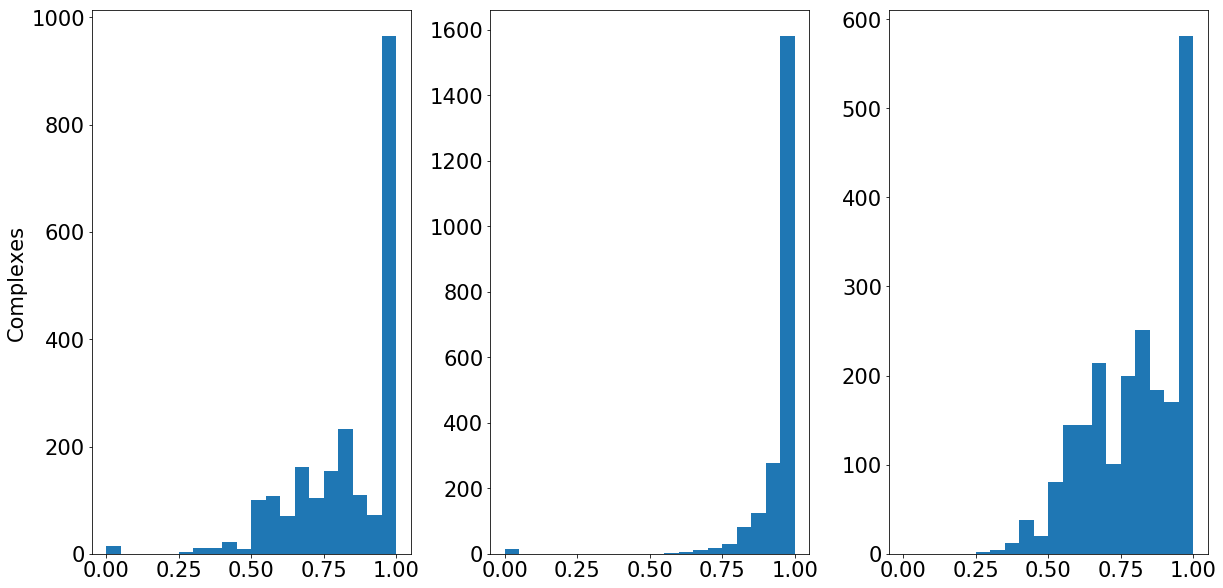

In [197]:
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(131)
ax1.hist(TERM_coverage_df["TERM coverage"],bins=20,range=(0,1))
plt.ylabel('Complexes')
ax2 = fig.add_subplot(132)
ax2.hist(TERM_coverage_df["TERM coverage (flanking)"],bins=20,range=(0,1))
ax3 = fig.add_subplot(133)
ax3.hist(TERM_coverage_df["Contact coverage"],bins=20,range=(0,1))
plt.subplots_adjust(wspace=.25)
axes.set_xlim([0,1600])
# fig = plt.subplot(1, 3, 1)
# fig = TERM_coverage_df["TERM coverage"].plot.hist(grid=True,bins=25)
# fig = plt.subplot(1, 3, 2)
# fig = TERM_coverage_df["TERM coverage (flanking)"].plot.hist(grid=True,bins=25)
# fig = plt.subplot(1, 3, 3)
# fig = TERM_coverage_df["Contact coverage"].plot.hist(grid=True,bins=25)
# plot.figure(dpi=50)

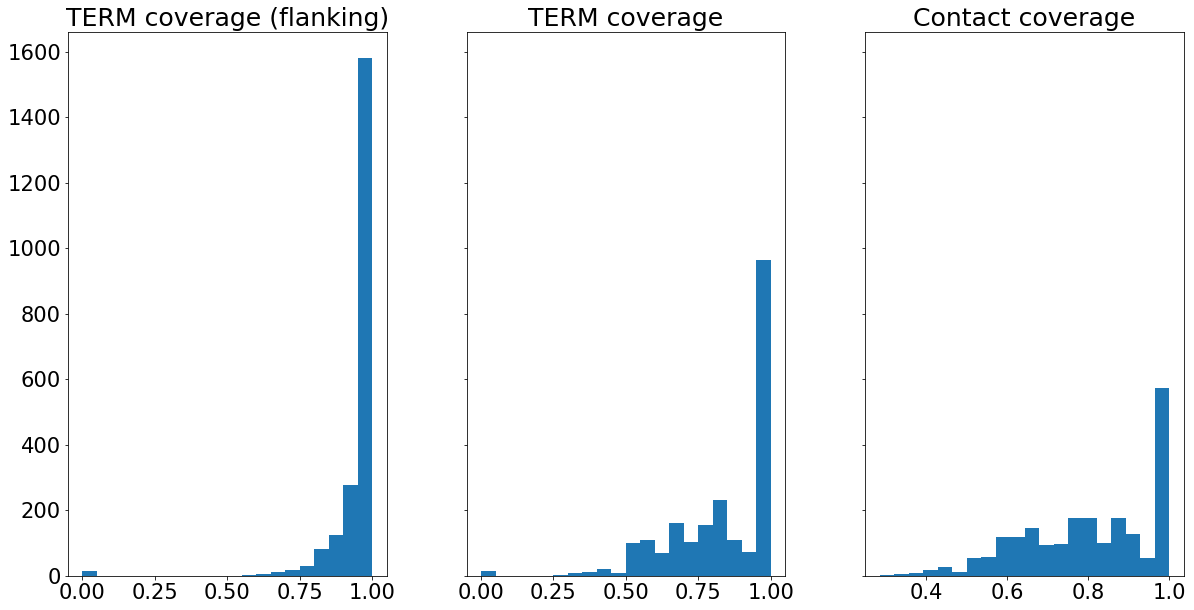

In [216]:
n_bins = 20
plt.rcParams.update({'font.size': 21})
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharey=True,figsize=(20,10))#, tight_layout=True)
ax1.hist(TERM_coverage_df["TERM coverage (flanking)"], bins=n_bins)
ax1.set_title("TERM coverage (flanking)")
ax2.hist(TERM_coverage_df["TERM coverage"], bins=n_bins)
ax2.set_title("TERM coverage")
ax3.hist(TERM_coverage_df["Contact coverage"], bins=n_bins)
ax3.set_title("Contact coverage")
fig.subplots_adjust(wspace=.25)


plt.savefig("ss_contacts_histograms.png")

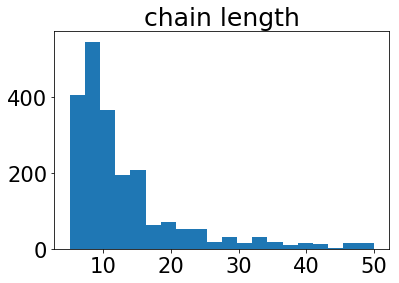

In [176]:
n_bins = 20
plt.rcParams.update({'font.size': 21})
plt.hist(TERM_coverage_df["chain length"], bins=n_bins)#, tight_layout=True)
plt.title("chain length")


plt.savefig("chain.png")

## Spearman correlation

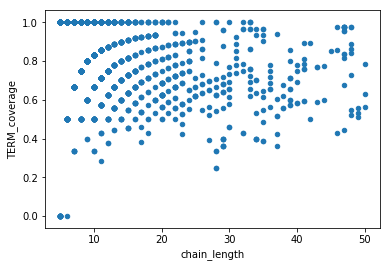

In [15]:
TERM_coverage_df.plot.scatter(x='chain_length',y='TERM_coverage')

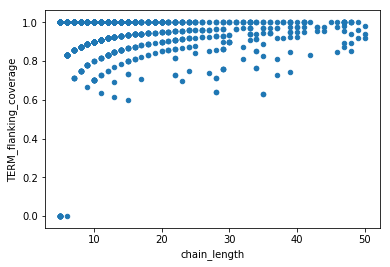

In [16]:
TERM_coverage_df.plot.scatter(x='chain_length',y='TERM_flanking_coverage')

## Table Data Analysis

In [199]:
TERM_coverage_df.mean()

chain length                13.035382
TERM coverage                0.835847
TERM coverage (flanking)     0.958972
Contact coverage             0.801997
dtype: float64

In [200]:
TERM_coverage_df.median()

chain length                10.000000
TERM coverage                0.875000
TERM coverage (flanking)     1.000000
Contact coverage             0.818182
dtype: float64

In [38]:
TERM_coverage_df.sort_values("TERM_coverage",ascending=True)

,complex,chain_length,TERM_coverage,TERM_flanking_coverage,contact_coverage
757,3FP2_A_Q_191_2,5,0.000000,0.000000,0.600000
680,1EVH_A_B_172_2,5,0.000000,0.000000,0.800000
193,4D0Z_E_Y_114_1,5,0.000000,0.000000,0.800000
1564,1GYB_AB_E_417_1,5,0.000000,0.000000,0.400000
396,4JX7_A_B_13_1,5,0.000000,0.000000,0.600000
1262,1F2S_E_I_3_1,28,0.291667,0.678571,0.392857
1311,1F2S_E_I_3_1,28,0.291667,0.678571,0.392857
1361,1MCT_A_I_3_1,28,0.333333,0.714286,0.428571
1384,1MCT_A_I_3_1,28,0.333333,0.714286,0.428571
758,3FP4_A_Q_191_1,7,0.333333,0.714286,0.428571


In [18]:
#percent of peptides with TERMs centered on all residues
sum(TERM_coverage_df['TERM_coverage'] > .99)/sum(TERM_coverage_df['TERM_coverage']>=0)

0.43947858472998136

In [19]:
#percent of peptides with flanking coverage on all residues
sum(TERM_coverage_df['TERM_flanking_coverage'] > .99)/sum(TERM_coverage_df['TERM_flanking_coverage']>=0)

0.7067039106145251

### Low CD Peptide Analysis

In [20]:
#given some pdb
file_path = "/scratch/users/swans/decorate_PixelDB_project/fragment_analysis/3D9T_B_D_99_1.cmap"
minor_chain = "D"
major_chain = "B"

with open(file_path,"r") as contact_f:
    contact_list = [str.split(line) for line in contact_f if re.search(minor_chain+",",line) and re.search(major_chain+",",line)]

contact_df = pd.DataFrame(contact_list,columns=["contact","B","D","CD","main_RES","minor_RES"])
print(contact_df)


    contact     B    D        CD main_RES minor_RES
0   contact  B,26  D,1  0.007999      VAL       ALA
1   contact  B,28  D,1  0.080793      VAL       ALA
2   contact  B,32  D,1  0.000014      GLN       ALA
3   contact  B,33  D,1  0.019973      LEU       ALA
4   contact  B,36  D,1  0.000073      ALA       ALA
5   contact  B,38  D,1  0.009256      PHE       ALA
6   contact  B,41  D,4  0.001055      VAL       PHE
7   contact  B,41  D,6  0.000336      VAL       GLU
8   contact  B,43  D,4  0.000884      ARG       PHE
9   contact  B,43  D,6  0.001594      ARG       GLU
10  contact  B,44  D,2  0.000059      ASN       THR
11  contact  B,44  D,4  0.004695      ASN       PHE
12  contact  B,44  D,6  0.000202      ASN       GLU
13  contact  B,45  D,1  0.005227      ASP       ALA
14  contact  B,46  D,2  0.000023      ASP       THR
15  contact  B,46  D,4  0.109583      ASP       PHE
16  contact  B,46  D,6  0.010121      ASP       GLU
17  contact  B,47  D,1  0.010196      VAL       ALA
18  contact 

In [21]:
contact_df.sort_values('CD')

,contact,B,D,CD,main_RES,minor_RES
26,contact,"B,55","D,3",0.000002,GLY,PRO
49,contact,"B,73","D,1",0.000003,PHE,ALA
23,contact,"B,53","D,5",0.000003,ASP,GLN
2,contact,"B,32","D,1",0.000014,GLN,ALA
14,contact,"B,46","D,2",0.000023,ASP,THR
21,contact,"B,49","D,3",0.000035,CYS,PRO
51,contact,"B,76","D,3",0.000057,CYS,PRO
10,contact,"B,44","D,2",0.000059,ASN,THR
48,contact,"B,72","D,5",0.000062,TRP,GLN
22,contact,"B,52","D,3",0.000071,CYS,PRO


# Analysis of complexes (ss,sb,bb)

## Practice

In [305]:
#given some pdb
file_path = "/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2"
prot_path = "/402/1/2EQ7_AB_C_402_1"
total_conts_path = file_path + prot_path + "/prot.conts"
total_pdb_path = file_path + prot_path + "/prot.pdb"
minor_chain = "C"

with open(total_conts_path,"r") as contact_f:
    contact_list = [str.split(line) for line in contact_f if len(re.findall(minor_chain+",",line)) == 1]
contact_df = pd.DataFrame(contact_list,columns=["contact type","main_chain_pos","RES","minor_chain_pos","RES","CD"])
#correct the order of contacts by chain name

for index in contact_df.index:
    if re.search(minor_chain+",",contact_df['minor_chain_pos'][index]) == None:
        contact_df.loc[index,'minor_chain_pos'],contact_df.loc[index,'main_chain_pos'] = contact_df.loc[index,'main_chain_pos'],contact_df.loc[index,'minor_chain_pos']
print(contact_df)

#find the chain length
chain_length = len(importPDB(total_pdb_path,chain_name='C',data_type='seq'))
chain_length
print('chain length is ',chain_length)
        
#find the list of residues with contacts
res_with_conts = list(set([int(x[2:]) for x in contact_df.iloc[:,3].tolist()]))
all_res_with_conts = [int(x[2:]) for x in contact_df.iloc[:,3].tolist()]
print("all conts",all_res_with_conts)
print("which res have conts",res_with_conts)

#contact network
with open(total_conts_path,"r") as contact_f:
    intra_contact_list = [str.split(line) for line in contact_f if len(re.findall(minor_chain+",",line)) == 2]
intra_contact_df = pd.DataFrame(intra_contact_list,columns=["contact type","minor_chain_pos1","RES","minor_chain_pos2","RES","CD"])
#print(intra_contact_df)

intra_res_with_conts = res_with_conts.copy()
for i in res_with_conts:
    intra_res_with_conts += [int(intra_contact_df.iloc[x,3][2:]) for x in range(len(intra_contact_df.iloc[:,1])) if int(intra_contact_df.iloc[x,1][2:]) == i]
    intra_res_with_conts += [int(intra_contact_df.iloc[x,1][2:]) for x in range(len(intra_contact_df.iloc[:,1])) if int(intra_contact_df.iloc[x,3][2:]) == i]
intra_res_with_conts = list(set(list(intra_res_with_conts)))

#print('did it work',intra_res_with_conts)

#make list of contacts for each residue
contacts_per_residue = [len([1 for j in all_res_with_conts if i == j]) for i in range(1,chain_length+1)]
print('interface contacts per residue',contacts_per_residue)

res_count = 0
flanking_list = list()

intra_res_count = 0
intra_flanking_list = list()
for i in range(3,chain_length-1):
    if i in res_with_conts:
        res_count += 1
        for j in range(i-2,i+3):
            flanking_list.append(j)
    if i in intra_res_with_conts:
        intra_res_count += 1
        for j in range(i-2,i+3):
            intra_flanking_list.append(j)
print(intra_flanking_list)
intra_flanking_list = list(set(list(intra_flanking_list)))
            
print(flanking_list)    
flanking_list = list(set(flanking_list))
print('TERM coverage',res_count/(chain_length-4))
print('TERM flanking coverage',len(flanking_list)/(chain_length))
print('contact coverage',len(res_with_conts)/chain_length)
print('intra TERM coverage',intra_res_count/(chain_length-4))
print('intra TERM flanking coverage',len(intra_flanking_list)/(chain_length))
#will add to dictionary

   contact type main_chain_pos  RES minor_chain_pos  RES         CD
0            ss          A,326  ARG            C,12  GLU  0.0694542
1            ss          A,328  PHE            C,12  GLU  0.0526811
2            ss          A,328  PHE            C,11  GLN   0.289692
3            ss          A,332  ASP             C,4  PRO   0.134232
4            ss          A,419  PHE             C,4  PRO   0.154786
5            ss          A,420  PHE             C,3  MET  0.0741373
6            ss          A,423  SER            C,26  GLY  0.0538228
7            ss          A,426  ASP            C,25  LEU   0.200121
8            ss          A,426  ASP            C,26  GLY    0.12162
9            ss          B,394  THR            C,32  GLU   0.443021
10           ss          B,396  ARG            C,30  LEU  0.0863738
11           ss          B,396  ARG            C,32  GLU   0.310722
12           ss          B,420  PHE            C,25  LEU  0.0611812
13           ss          B,421  LYS            C

In [222]:
#given some pdb
file_path = "/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2"
prot_path = "/99/4/3D9T_B_D_99_1"
total_conts_path = file_path + prot_path + "/prot.conts"
total_pdb_path = file_path + prot_path + "/prot.pdb"
minor_chain = "D"

with open(total_conts_path,"r") as contact_f:
    contact_list = [str.split(line) for line in contact_f if len(re.findall(minor_chain+",",line)) == 1]

contact_df = pd.DataFrame(contact_list,columns=["contact type","main_chain_pos","RES","minor_chain_pos","RES","CD"])

#correct the order of contacts by chain name

for index in contact_df.index:
    if re.search(minor_chain+",",contact_df['minor_chain_pos'][index]) == None:
        contact_df.loc[index,'minor_chain_pos'],contact_df.loc[index,'main_chain_pos'] = contact_df.loc[index,'main_chain_pos'],contact_df.loc[index,'minor_chain_pos']
print(contact_df)

#find the chain length
chain_length = len(importPDB(total_pdb_path,chain_name='D',data_type='seq'))
chain_length
print('chain length is ',chain_length)
        
#find the list of residues with contacts
res_with_conts = list(set([int(x[2:]) for x in contact_df.iloc[:,3].tolist()]))
all_res_with_conts = [int(x[2:]) for x in contact_df.iloc[:,3].tolist()]
print(all_res_with_conts)
print(res_with_conts)

#contact network
with open(total_conts_path,"r") as contact_f:
    intra_contact_list = [str.split(line) for line in contact_f if len(re.findall(minor_chain+",",line)) == 2]
intra_contact_df = pd.DataFrame(intra_contact_list,columns=["contact type","minor_chain_pos1","RES","minor_chain_pos2","RES","CD"])
#print(intra_contact_df)

intra_res_with_conts = res_with_conts.copy()
for i in res_with_conts:
    intra_res_with_conts += [int(intra_contact_df.iloc[x,3][2:]) for x in range(len(intra_contact_df.iloc[:,1])) if int(intra_contact_df.iloc[x,1][2:]) == i]
    intra_res_with_conts += [int(intra_contact_df.iloc[x,1][2:]) for x in range(len(intra_contact_df.iloc[:,1])) if int(intra_contact_df.iloc[x,3][2:]) == i]
intra_res_with_conts = list(set(list(intra_res_with_conts)))

#print('did it work',intra_res_with_conts)

#make list of contacts for each residue
contacts_per_residue = [len([1 for j in all_res_with_conts if i == j]) for i in range(1,chain_length+1)]
print('interface contacts per residue',contacts_per_residue)

#make list of contacts for each residue
contacts_per_residue = [len([1 for j in all_res_with_conts if i == j]) for i in range(1,chain_length+1)]
print('test',contacts_per_residue)

res_count = 0
flanking_list = list()

intra_res_count = 0
intra_flanking_list = list()
for i in range(3,chain_length-1):
    if i in res_with_conts:
        res_count += 1
        for j in range(i-2,i+3):
            flanking_list.append(j)
    if i in intra_res_with_conts:
        intra_res_count += 1
        for j in range(i-2,i+3):
            intra_flanking_list.append(j)
print(flanking_list)    
flanking_list = list(set(flanking_list))
intra_flanking_list = list(set(list(intra_flanking_list)))
print('TERM coverage',res_count/(chain_length-4))
print('TERM flanking coverage',len(flanking_list)/(chain_length))
print('contact coverage',len(res_with_conts)/chain_length)
print('intra TERM coverage',intra_res_count/(chain_length-4))
print('intra TERM flanking coverage',len(intra_flanking_list)/(chain_length))

#will add to dictionary

   contact type main_chain_pos  RES minor_chain_pos  RES         CD
0            ss           B,28  VAL             D,1  ALA  0.0720041
1            ss           B,46  ASP             D,4  PHE    0.26955
2            ss           B,54  GLY             D,3  PRO    0.14789
3            ss           B,55  GLY             D,4  PHE   0.261161
4            ss           B,56  LEU             D,1  ALA   0.394913
5            ss           B,56  LEU             D,3  PRO  0.0775154
6            ss           B,57  ARG             D,2  THR  0.0761681
7            ss           B,57  ARG             D,4  PHE   0.457751
8            ss           B,58  CYS             D,2  THR   0.160506
9            ss           B,59  TRP             D,1  ALA    0.38115
10           ss           B,63  ASP             D,1  ALA   0.226159
11           ss           B,68  GLU             D,1  ALA   0.370521
12           ss           B,72  TRP             D,3  PRO   0.375066
13           ss           B,73  PHE             

In [309]:
subclus_conts_path = "/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2"
all_proteins_path = "/*/*/*/prot.conts"

call = "find " + subclus_conts_path+all_proteins_path
all_protein_conts = subprocess.check_output(call,shell=True)
all_protein_conts = str.split(all_protein_conts.rstrip().decode('utf-8'),'\n')

TERM_coverage_2 = list()

for protein in all_protein_conts:
    
    print(protein)
    minor_chain = protein.split('/')[-2].split('_')[-3]
    
    with open(protein,"r") as contact_f:
        contact_list = [str.split(line) for line in contact_f if len(re.findall(minor_chain+",",line)) == 1]

        contact_df = pd.DataFrame(contact_list,columns=["contact type","main_chain_pos","RES","minor_chain_pos","RES","CD"])
        #print(contact_df)
        
        #correct the order of contacts by chain name

        for index in contact_df.index:
            if re.search(minor_chain+",",contact_df['minor_chain_pos'][index]) == None:
                contact_df.loc[index,'minor_chain_pos'],contact_df.loc[index,'main_chain_pos'] = contact_df.loc[index,'main_chain_pos'],contact_df.loc[index,'minor_chain_pos']


        #find the chain length
        chain_length = len(importPDB(protein[:-5]+'pdb',chain_name=minor_chain,data_type='seq'))
        #print(chain_length)
        

        #find the list of residues with contacts
        res_with_conts = list(set([int(x[2:]) for x in contact_df.iloc[:,3].tolist()]))
        all_res_with_conts = [int(x[2:]) for x in contact_df.iloc[:,3].tolist()]
        
        #contact network
        with open(total_conts_path,"r") as contact_f:
            intra_contact_list = [str.split(line) for line in contact_f if len(re.findall(minor_chain+",",line)) == 2]
        intra_contact_df = pd.DataFrame(intra_contact_list,columns=["contact type","minor_chain_pos1","RES","minor_chain_pos2","RES","CD"])
        #print(intra_contact_df)

        intra_res_with_conts = res_with_conts.copy()
        for i in res_with_conts:
            intra_res_with_conts += [int(intra_contact_df.iloc[x,3][2:]) for x in range(len(intra_contact_df.iloc[:,1])) if int(intra_contact_df.iloc[x,1][2:]) == i]
            intra_res_with_conts += [int(intra_contact_df.iloc[x,1][2:]) for x in range(len(intra_contact_df.iloc[:,1])) if int(intra_contact_df.iloc[x,3][2:]) == i]
        intra_res_with_conts = list(set(list(intra_res_with_conts)))

        #print('did it work',intra_res_with_conts)
        
        #make list of contacts for each residue
        contacts_per_residue = [len([1 for j in all_res_with_conts if i == j]) for i in range(1,chain_length+1)]
        
        flank_list = list()
        res_count = 0
        intra_res_count = 0
        intra_flanking_list = list()
        for i in range(3,chain_length-1):
            if i in res_with_conts:
                res_count += 1
                flank_list += list(range(i-2,i+3))
            if i in intra_res_with_conts:
                intra_res_count += 1
                for j in range(i-2,i+3):
                    intra_flanking_list.append(j)
        flank_list = list(set(flank_list))
        intra_flanking_list = list(set(list(intra_flanking_list)))
        
        print('TERM coverage',res_count/(chain_length-4))
        print('TERM flanking coverage',len(flank_list)/(chain_length))
        print('contact coverage',len(res_with_conts)/chain_length)
        print('Contacts per residue',contacts_per_residue)
        print('intra TERM coverage',intra_res_count/(chain_length-4))
        print('intra TERM flanking coverage',len(intra_flanking_list)/(chain_length))
        
        TERM_coverage_2.append([protein.split('/')[-2],chain_length,res_count/(chain_length-4),len(flank_list)/chain_length,len(res_with_conts)/chain_length,contacts_per_residue,intra_res_count/(chain_length-4),len(intra_flanking_list)/(chain_length)])
        
TERM_coverage_2_df = pd.DataFrame(TERM_coverage_2,columns=["complex","chain_length","TERM coverage","TERM coverage (flanking)","Contact coverage","Contacts per residue","Second Order TERM coverage","Second Order TERM coverage (flanking)"])
TERM_coverage_2_df

/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/100/1/1OU8_A_C_100_1/prot.conts
TERM coverage 0.8571428571428571
TERM flanking coverage 0.9090909090909091
contact coverage 0.7272727272727273
Contacts per residue [0, 0, 0, 1, 6, 5, 4, 4, 4, 1, 8]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/100/1/1TWB_A_C_100_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [6, 6, 6, 4, 4, 1, 8, 1]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/100/2/1YFN_C_G_100_2/prot.conts
TERM coverage 0.7272727272727273
TERM flanking coverage 1.0
contact coverage 0.7333333333333333
Contacts per residue [3, 2, 6, 2, 1, 3, 0, 0, 3, 1, 0, 4, 3, 8, 0]
intra TERM coverage 0.7272727272727273
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/sub

TERM coverage 0.75
TERM flanking coverage 0.875
contact coverage 0.75
Contacts per residue [6, 1, 0, 0, 2, 5, 1, 2, 2, 0, 2, 1, 3, 6, 0, 1]
intra TERM coverage 0.9166666666666666
intra TERM flanking coverage 0.9375
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/106/1/4YFA_F_E_106_1/prot.conts
TERM coverage 0.8181818181818182
TERM flanking coverage 1.0
contact coverage 0.8
Contacts per residue [7, 1, 1, 0, 2, 4, 1, 1, 1, 0, 1, 1, 3, 5, 0]
intra TERM coverage 0.8181818181818182
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/106/1/4YFB_F_E_106_1/prot.conts
TERM coverage 0.7
TERM flanking coverage 0.8571428571428571
contact coverage 0.7857142857142857
Contacts per residue [6, 1, 0, 0, 2, 4, 1, 2, 1, 0, 2, 2, 3, 7]
intra TERM coverage 0.7
intra TERM flanking coverage 0.8571428571428571
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/107/1/1CSB_E_D_107_1/prot.conts
TERM cove

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [3, 8, 6, 5, 3, 1, 4, 3, 3, 10]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/10/3WLB_A_C_1_1/prot.conts
TERM coverage 0.8333333333333334
TERM flanking coverage 1.0
contact coverage 0.9
Contacts per residue [3, 7, 5, 3, 1, 0, 3, 4, 2, 9]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/10/4F7M_D_F_1_1/prot.conts
TERM coverage 0.8333333333333334
TERM flanking coverage 1.0
contact coverage 0.9
Contacts per residue [3, 8, 6, 3, 2, 3, 0, 3, 4, 9]
intra TERM coverage 0.8333333333333334
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/10/4F7T_D_F_1_3/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [4, 9, 4, 2, 7, 4, 4, 9]
in

TERM coverage 0.75
TERM flanking coverage 0.8333333333333334
contact coverage 0.75
Contacts per residue [0, 2, 0, 3, 6, 11, 8, 6, 6, 0, 2, 4]
intra TERM coverage 0.75
intra TERM flanking coverage 0.8333333333333334
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/11/1/4ES0_A_C_11_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8571428571428571
Contacts per residue [7, 10, 8, 6, 8, 0, 6]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/11/1/4EWR_A_C_11_1/prot.conts
TERM coverage 0.8333333333333334
TERM flanking coverage 0.9
contact coverage 0.8
Contacts per residue [0, 5, 5, 10, 8, 6, 8, 0, 5, 5]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/11/1/4O45_A_B_11_4/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8
Contacts per residue [10, 6,

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [6, 8, 7, 1, 2, 6, 4, 4, 10]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/112/1/3OBX_A_B_112_1/prot.conts
TERM coverage 0.8
TERM flanking coverage 0.8888888888888888
contact coverage 0.6666666666666666
Contacts per residue [2, 0, 7, 3, 8, 7, 0, 4, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/112/1/4EJE_B_D_112_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.7777777777777778
Contacts per residue [2, 0, 8, 2, 7, 7, 2, 4, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/112/1/4ZNY_A_B_112_1/prot.conts
TERM coverage 0.8333333333333334
TERM flanking coverage 0.9
contact coverage 0.7
Contacts per residue [0, 3, 0, 6,

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.9473684210526315
Contacts per residue [6, 0, 4, 3, 4, 6, 1, 2, 5, 3, 5, 3, 3, 3, 3, 1, 3, 1, 1]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/13/2ZOK_G_L_1_3/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [10, 4, 2, 5, 2, 4, 4, 11]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/13/3QUK_D_F_1_2/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [4, 9, 7, 2, 3, 2, 4, 4, 11]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/13/3TBY_J_L_1_2/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [6, 9, 8, 1, 3, 3, 4, 4, 10]
intra TE

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [2, 8, 4, 2, 5, 1, 4, 2, 9]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/1/3MRD_A_P_1_2/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [3, 9, 5, 2, 3, 2, 4, 4, 9]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/1/3MRE_A_P_1_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [7, 7, 6, 2, 4, 2, 3, 3, 11]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/1/3MRF_A_P_1_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [6, 7, 5, 2, 3, 3, 5, 3, 10]
intra TERM coverage 1.0
intra TERM flanking coverage 1.

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [7, 6, 4, 3, 6, 5, 3, 9]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/14/3FOM_A_P_1_2/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [4, 8, 4, 3, 5, 4, 3, 11]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/14/3FON_C_E_1_2/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [6, 6, 4, 4, 7, 4, 4, 9]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/14/4WDI_D_F_1_2/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [2, 11, 3, 4, 7, 2, 5, 3, 10]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/sc

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [7, 7, 11, 6, 7, 4, 5]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/16/1BII_A_P_1_2/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [3, 9, 5, 2, 4, 2, 3, 3, 4, 11]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/116/2/3NJI_A_B_116_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [9, 14, 19, 13, 13, 10, 8]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/16/2DYP_A_C_1_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [5, 7, 5, 2, 2, 6, 8, 1, 11]
intra TERM coverage 1.0
intra TERM flanking coverage

TERM coverage 0.6875
TERM flanking coverage 1.0
contact coverage 0.6
Contacts per residue [0, 2, 4, 0, 0, 6, 5, 0, 2, 8, 2, 0, 4, 8, 1, 0, 5, 4, 0, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/119/1/4ZIG_A_B_119_1/prot.conts
TERM coverage 0.8125
TERM flanking coverage 0.9
contact coverage 0.8
Contacts per residue [1, 0, 0, 4, 5, 1, 1, 7, 7, 1, 2, 7, 5, 0, 3, 8, 2, 0, 4, 2]
intra TERM coverage 0.9375
intra TERM flanking coverage 0.95
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/119/1/4ZII_A_C_119_1/prot.conts
TERM coverage 0.75
TERM flanking coverage 0.9583333333333334
contact coverage 0.6666666666666666
Contacts per residue [0, 0, 0, 1, 0, 0, 6, 6, 1, 1, 6, 6, 1, 4, 7, 6, 0, 4, 8, 3, 0, 7, 2, 0]
intra TERM coverage 0.95
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/19/3BXN_A_C_1_2/prot.conts
TERM cover

TERM coverage 0.8823529411764706
TERM flanking coverage 1.0
contact coverage 0.8095238095238095
Contacts per residue [5, 7, 4, 8, 6, 3, 4, 6, 4, 1, 3, 3, 1, 2, 1, 0, 0, 1, 1, 0, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/12/1/2Y4V_A_B_12_3/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [3, 8, 3, 2, 5, 5, 1, 4, 4, 3, 5, 4, 3, 3, 6, 3]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/21/3BEV_A_C_1_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [5, 8, 6, 1, 2, 6, 2, 6, 8, 4, 10]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/12/1/3BXL_A_B_12_5/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contact

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.95
Contacts per residue [3, 5, 4, 8, 6, 4, 1, 6, 5, 5, 1, 5, 6, 6, 4, 4, 2, 1, 3, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/12/2/3DVE_A_B_12_1/prot.conts
TERM coverage 0.9473684210526315
TERM flanking coverage 0.9565217391304348
contact coverage 0.8695652173913043
Contacts per residue [4, 6, 6, 8, 4, 1, 5, 6, 2, 5, 5, 4, 4, 7, 7, 2, 1, 4, 1, 1, 0, 0, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/2/2AXF_A_C_1_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [4, 7, 4, 2, 4, 2, 3, 4, 4, 10]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/2/2AXG_A_C_1_4/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0


TERM coverage 0.6666666666666666
TERM flanking coverage 1.0
contact coverage 0.7692307692307693
Contacts per residue [5, 7, 6, 3, 1, 1, 0, 0, 0, 3, 4, 5, 11]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/2/3VFS_A_C_1_1/prot.conts
TERM coverage 0.6666666666666666
TERM flanking coverage 1.0
contact coverage 0.7692307692307693
Contacts per residue [5, 7, 6, 2, 5, 0, 2, 0, 0, 2, 4, 5, 10]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/2/3VFT_A_C_1_1/prot.conts
TERM coverage 0.6666666666666666
TERM flanking coverage 1.0
contact coverage 0.7692307692307693
Contacts per residue [5, 7, 6, 3, 1, 1, 0, 0, 0, 2, 5, 5, 11]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/2/3VFU_A_C_1_4/prot.conts
TERM coverage 0.6666666666666666
TERM flank

TERM coverage 0.6
TERM flanking coverage 0.9583333333333334
contact coverage 0.625
Contacts per residue [4, 0, 1, 3, 4, 0, 0, 4, 1, 0, 0, 5, 0, 0, 3, 5, 1, 0, 2, 6, 1, 0, 2, 6]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/126/1/2P8Q_A_B_126_1/prot.conts
TERM coverage 0.6571428571428571
TERM flanking coverage 1.0
contact coverage 0.6923076923076923
Contacts per residue [2, 3, 1, 0, 1, 3, 4, 0, 4, 0, 3, 4, 3, 0, 1, 0, 0, 1, 3, 0, 0, 3, 3, 0, 1, 4, 2, 0, 2, 6, 1, 0, 2, 6, 1, 0, 2, 7, 1]
intra TERM coverage 0.9714285714285714
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/12/6/1QTX_A_B_12_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.95
Contacts per residue [3, 1, 4, 5, 4, 5, 5, 5, 5, 8, 5, 4, 5, 4, 4, 3, 5, 5, 0, 1]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_p

TERM coverage 0.8
TERM flanking coverage 1.0
contact coverage 0.7777777777777778
Contacts per residue [1, 0, 3, 0, 2, 3, 2, 8, 3]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/13/1/3CY3_A_B_13_1/prot.conts
TERM coverage 0.75
TERM flanking coverage 1.0
contact coverage 0.75
Contacts per residue [1, 0, 2, 0, 2, 3, 2, 12]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/13/1/3MA3_A_B_13_1/prot.conts
TERM coverage 0.6666666666666666
TERM flanking coverage 0.8571428571428571
contact coverage 0.8571428571428571
Contacts per residue [1, 2, 0, 3, 3, 1, 7]
intra TERM coverage 0.6666666666666666
intra TERM flanking coverage 0.8571428571428571
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/13/1/4GW8_A_B_13_1/prot.conts
TERM coverage 0.8
TERM flanking coverage 1.0
contact coverage 0.6666666666666666
C

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [6, 9, 5, 2, 5, 6, 3, 11]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/133/2/4HRG_A_C_133_2/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [6, 3, 6, 8, 2, 6, 3, 6]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/13/3/3BU3_A_B_13_3/prot.conts
TERM coverage 0.8
TERM flanking coverage 1.0
contact coverage 0.8571428571428571
Contacts per residue [8, 2, 2, 2, 0, 0, 3, 3, 6, 2, 6, 1, 9, 9]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/13/3/3BU5_A_B_13_3/prot.conts
TERM coverage 0.75
TERM flanking coverage 0.8333333333333334
contact coverage 0.8333333333333334
Contacts per residue [2, 2, 0, 0, 3, 3, 6,

TERM coverage 0.7333333333333333
TERM flanking coverage 0.9411764705882353
contact coverage 0.7352941176470589
Contacts per residue [0, 4, 0, 0, 3, 3, 0, 4, 3, 1, 1, 6, 4, 3, 5, 6, 9, 0, 1, 4, 4, 4, 5, 4, 0, 0, 0, 3, 3, 0, 2, 5, 2, 4]
intra TERM coverage 0.7333333333333333
intra TERM flanking coverage 0.9411764705882353
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/13/6/1NVS_A_B_13_6/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [2, 4, 7, 3, 5]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/136/2/1Y3A_A_E_136_2/prot.conts
TERM coverage 0.875
TERM flanking coverage 1.0
contact coverage 0.8333333333333334
Contacts per residue [1, 4, 4, 1, 5, 3, 0, 3, 3, 1, 1, 0]
intra TERM coverage 0.875
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/36/3PWU_A_C_1_2/prot.conts

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [5, 6, 7, 2, 7, 3, 4, 9]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/4/1LEG_A_P_1_2/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [5, 8, 6, 2, 7, 2, 4, 9]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/4/1LK2_A_P_1_2/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [6, 8, 8, 2, 8, 2, 4, 7]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/4/1OSZ_A_C_1_2/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [3, 7, 4, 2, 7, 4, 4, 10]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/us

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.9166666666666666
Contacts per residue [0, 4, 7, 11, 11, 5, 8, 7, 8, 9, 7, 10]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/14/3/3P8N_B_D_14_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [1, 3, 8, 11, 10, 4, 7, 7, 10, 11, 5, 7, 2]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/14/3/4JMY_B_F_14_2/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [4, 3, 2, 5, 5, 10]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/4/3P4M_D_C_1_3/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [3, 7, 5, 4, 6, 4, 2, 11]
intra TERM coverage 

TERM coverage 0.7241379310344828
TERM flanking coverage 0.9393939393939394
contact coverage 0.7272727272727273
Contacts per residue [0, 2, 0, 0, 3, 1, 0, 0, 2, 0, 1, 2, 1, 1, 3, 6, 5, 0, 3, 4, 1, 0, 4, 0, 4, 8, 6, 1, 2, 5, 3, 2, 7]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/148/1/1I51_AB_E_148_1/prot.conts
TERM coverage 0.8571428571428571
TERM flanking coverage 1.0
contact coverage 0.7222222222222222
Contacts per residue [0, 0, 3, 0, 0, 1, 5, 1, 3, 6, 2, 3, 2, 6, 4, 4, 4, 0]
intra TERM coverage 0.8571428571428571
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/149/1/4ZOX_A_B_149_1/prot.conts
TERM coverage 0.8
TERM flanking coverage 1.0
contact coverage 0.7857142857142857
Contacts per residue [3, 3, 3, 3, 1, 1, 4, 0, 7, 6, 0, 5, 1, 0]
intra TERM coverage 0.9
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/su

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [2, 7, 1, 8, 1, 4, 5, 1]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/15/2/3P4K_A_P_15_1/prot.conts
TERM coverage 0.7142857142857143
TERM flanking coverage 0.8181818181818182
contact coverage 0.8181818181818182
Contacts per residue [9, 2, 0, 7, 2, 6, 1, 5, 0, 2, 1]
intra TERM coverage 0.7142857142857143
intra TERM flanking coverage 0.8181818181818182
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/5/2A83_A_C_1_2/prot.conts
TERM coverage 0.8
TERM flanking coverage 1.0
contact coverage 0.8888888888888888
Contacts per residue [7, 5, 4, 2, 3, 0, 2, 3, 10]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/5/2BSR_A_C_1_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts p

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8333333333333334
Contacts per residue [8, 4, 3, 3, 0, 4]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/15/5/1UKH_A_B_15_1/prot.conts
TERM coverage 0.6666666666666666
TERM flanking coverage 0.9
contact coverage 0.6
Contacts per residue [3, 0, 2, 6, 0, 2, 9, 0, 5, 0]
intra TERM coverage 0.8333333333333334
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/15/5/3PTG_A_J_15_1/prot.conts
TERM coverage 0.8333333333333334
TERM flanking coverage 0.9
contact coverage 0.6
Contacts per residue [0, 0, 2, 5, 1, 2, 10, 0, 6, 0]
intra TERM coverage 0.8333333333333334
intra TERM flanking coverage 0.9
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/15/5/4E73_A_B_15_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.6666666666666666
Contacts per

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [2, 4, 9, 8, 1, 4, 1]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/16/1/4EZP_B_D_16_1/prot.conts
TERM coverage 0.6666666666666666
TERM flanking coverage 0.7692307692307693
contact coverage 0.5384615384615384
Contacts per residue [0, 6, 4, 10, 11, 5, 2, 5, 0, 0, 0, 0, 0]
intra TERM coverage 0.6666666666666666
intra TERM flanking coverage 0.7692307692307693
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/16/1/4EZQ_A_B_16_2/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [7, 6, 2, 10, 6, 4, 2]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/16/1/4EZR_A_B_16_2/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [4, 10, 5, 4, 7, 1, 4, 6, 11]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/6/3SPV_A_C_1_2/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [4, 8, 5, 3, 7, 5, 4, 11]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/6/3X14_A_C_1_2/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [5, 8, 6, 4, 5, 4, 5, 6, 10]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/164/1/3VIV_AB_C_164_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [7, 11, 6, 8, 8, 5, 9, 8]
intra TERM coverage 1.0
intra TERM flanking coverage 

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8333333333333334
Contacts per residue [0, 4, 7, 5, 1, 1]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/17/1/1VWO_B_P_17_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.875
Contacts per residue [0, 6, 7, 5, 1, 3, 3, 3]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/171/2/4X3H_A_B_171_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8888888888888888
Contacts per residue [3, 8, 7, 6, 8, 6, 5, 1, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/17/1/2G5L_A_X_17_3/prot.conts
TERM coverage 0.5
TERM flanking coverage 0.8333333333333334
contact coverage 0.8333333333333334
Contacts per residue [1, 3, 1, 0, 4, 6]
intra TE

TERM coverage 0.6
TERM flanking coverage 0.8571428571428571
contact coverage 0.5714285714285714
Contacts per residue [0, 4, 0, 3, 2, 0, 3, 5, 0, 5, 4, 0, 1, 0]
intra TERM coverage 0.6
intra TERM flanking coverage 0.8571428571428571
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/177/2/4LD3_A_B_177_1/prot.conts
TERM coverage 0.6666666666666666
TERM flanking coverage 1.0
contact coverage 0.5
Contacts per residue [0, 0, 5, 0, 5, 3, 0, 3, 5, 0, 4, 4, 0, 3, 0, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/178/1/4K38_B_C_178_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [6, 5, 6, 4, 5, 8, 7, 4, 4, 3, 3]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/178/1/4K39_B_D_178_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact cover

TERM coverage 0.6666666666666666
TERM flanking coverage 0.9230769230769231
contact coverage 0.6153846153846154
Contacts per residue [1, 0, 4, 0, 2, 6, 2, 0, 5, 4, 0, 0, 2]
intra TERM coverage 0.6666666666666666
intra TERM flanking coverage 0.9230769230769231
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/18/3/2NPA_A_B_18_1/prot.conts
TERM coverage 0.7272727272727273
TERM flanking coverage 0.9333333333333333
contact coverage 0.7333333333333333
Contacts per residue [1, 6, 0, 1, 4, 0, 2, 6, 2, 0, 5, 5, 1, 0, 1]
intra TERM coverage 0.9090909090909091
intra TERM flanking coverage 0.9333333333333333
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/18/3/2P54_A_B_18_1/prot.conts
TERM coverage 0.75
TERM flanking coverage 1.0
contact coverage 0.5833333333333334
Contacts per residue [0, 0, 4, 0, 3, 7, 2, 0, 2, 6, 1, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments

TERM coverage 0.5384615384615384
TERM flanking coverage 0.9411764705882353
contact coverage 0.47058823529411764
Contacts per residue [0, 1, 0, 3, 0, 0, 2, 4, 0, 1, 5, 0, 0, 3, 4, 0, 0]
intra TERM coverage 0.9230769230769231
intra TERM flanking coverage 0.9411764705882353
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/190/1/4KBB_B_D_190_1/prot.conts
TERM coverage 0.5714285714285714
TERM flanking coverage 1.0
contact coverage 0.5555555555555556
Contacts per residue [0, 3, 1, 0, 1, 4, 0, 0, 2, 4, 0, 1, 4, 0, 0, 4, 5, 0]
intra TERM coverage 0.5714285714285714
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/19/10/4AFX_A_B_19_1/prot.conts
TERM coverage 0.9333333333333333
TERM flanking coverage 1.0
contact coverage 0.9411764705882353
Contacts per residue [4, 6, 2, 7, 1, 5, 4, 4, 0, 3, 6, 3, 6, 7, 5, 4, 4, 2, 6, 4, 6, 4, 7, 7, 6, 5, 5, 3, 0, 3, 4, 4, 1, 4]
intra TERM coverage 1.0
intra TERM flanking cover

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [4, 11, 6, 1, 5, 1, 3, 6, 2, 9]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/9/3UPR_C_Q_1_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [5, 8, 5, 1, 3, 3, 4, 2, 6]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/9/3VH8_A_C_1_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [5, 8, 6, 2, 7, 2, 7, 2, 11]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/1/9/3VRI_A_C_1_1/prot.conts
TERM coverage 0.8333333333333334
TERM flanking coverage 1.0
contact coverage 0.9
Contacts per residue [7, 8, 6, 2, 4, 0, 3, 4, 3, 8]
intra TERM coverage 1.0
intra TERM

TERM coverage 0.75
TERM flanking coverage 1.0
contact coverage 0.6875
Contacts per residue [0, 5, 1, 10, 1, 7, 0, 2, 7, 7, 6, 0, 0, 4, 4, 0]
intra TERM coverage 0.75
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/19/8/1A7C_A_B_19_2/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [9, 6, 8, 10, 9]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/19/8/1A7C_A_C_19_3/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [7, 9, 8, 9, 4]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/199/1/2YLE_A_B_199_1/prot.conts
TERM coverage 0.5294117647058824
TERM flanking coverage 0.8571428571428571
contact coverage 0.6190476190476191
Contacts per residue [3, 4, 0, 2, 4, 4, 0, 4, 0, 

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [2, 4, 4, 5, 2, 8]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/20/3/1RZX_A_B_20_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [2, 1, 5, 4, 4, 10]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/20/3/1X8S_A_B_20_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [4, 2, 5, 5, 2, 9, 6, 3, 1]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/203/2/3GJF_DKM_F_203_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [6, 7, 4, 5, 6, 4, 6, 7, 10]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scrat

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [1, 3, 3, 7, 2, 4]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/21/1/1CZY_C_E_21_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [5, 5, 6, 7, 3, 1, 6]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/21/1/1D01_D_G_21_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [3, 2, 9, 4, 5, 7, 2]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/21/1/1D0A_A_G_21_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [8, 3, 5, 9, 2]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decora

TERM coverage 0.7142857142857143
TERM flanking coverage 0.9090909090909091
contact coverage 0.7272727272727273
Contacts per residue [2, 6, 0, 2, 7, 2, 0, 3, 6, 1, 0]
intra TERM coverage 0.8571428571428571
intra TERM flanking coverage 0.9090909090909091
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/2/1/2Q7K_A_B_2_2/prot.conts
TERM coverage 0.8333333333333334
TERM flanking coverage 1.0
contact coverage 0.7
Contacts per residue [0, 3, 6, 1, 0, 4, 6, 1, 0, 1]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/213/1/2Z3N_A_C_213_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [9, 5, 6, 4, 3]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/21/3/1QSC_A_D_21_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per 

TERM coverage 0.8
TERM flanking coverage 1.0
contact coverage 0.7777777777777778
Contacts per residue [4, 0, 3, 4, 2, 0, 4, 6, 1]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/2/15/3OMQ_B_D_2_1/prot.conts
TERM coverage 0.6666666666666666
TERM flanking coverage 0.9
contact coverage 0.8
Contacts per residue [1, 2, 0, 2, 6, 2, 0, 4, 6, 1]
intra TERM coverage 0.6666666666666666
intra TERM flanking coverage 0.9
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/2/15/4J24_D_L_2_1/prot.conts
TERM coverage 0.6666666666666666
TERM flanking coverage 0.9
contact coverage 0.7
Contacts per residue [2, 3, 0, 2, 6, 2, 0, 4, 6, 0]
intra TERM coverage 0.6666666666666666
intra TERM flanking coverage 0.9
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/216/1/3V43_A_Q_216_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8571428571428571
Cont

TERM coverage 0.8333333333333334
TERM flanking coverage 1.0
contact coverage 0.8
Contacts per residue [4, 1, 3, 8, 2, 0, 4, 6, 1, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/222/1/2XZQ_L_P_222_2/prot.conts
TERM coverage 0.8
TERM flanking coverage 0.8888888888888888
contact coverage 0.8888888888888888
Contacts per residue [2, 6, 8, 3, 3, 3, 0, 1, 2]
intra TERM coverage 0.8
intra TERM flanking coverage 0.8888888888888888
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/22/2/1BQP_C_D_22_1/prot.conts
TERM coverage 0.9767441860465116
TERM flanking coverage 1.0
contact coverage 0.9787234042553191
Contacts per residue [3, 5, 3, 6, 4, 7, 3, 4, 3, 6, 1, 7, 3, 0, 5, 5, 2, 4, 4, 6, 6, 8, 10, 8, 11, 7, 10, 5, 12, 2, 4, 6, 9, 8, 6, 7, 5, 5, 6, 4, 5, 7, 5, 10, 4, 9, 2]
intra TERM coverage 0.9767441860465116
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_proje

TERM coverage 0.8333333333333334
TERM flanking coverage 1.0
contact coverage 0.7
Contacts per residue [0, 4, 3, 8, 3, 0, 3, 6, 1, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/2/2/4MGD_A_F_2_2/prot.conts
TERM coverage 0.8
TERM flanking coverage 1.0
contact coverage 0.7777777777777778
Contacts per residue [2, 3, 8, 2, 0, 3, 6, 1, 0]
intra TERM coverage 0.8
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/2/2/4PPS_A_C_2_1/prot.conts
TERM coverage 0.75
TERM flanking coverage 0.9166666666666666
contact coverage 0.6666666666666666
Contacts per residue [0, 4, 3, 8, 2, 0, 4, 6, 1, 0, 1, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/2/2/4ZN9_A_C_2_2/prot.conts
TERM coverage 0.8333333333333334
TERM flanking coverage 1.0
contact coverage 0.7
Contacts per resid

TERM coverage 0.75
TERM flanking coverage 1.0
contact coverage 0.5833333333333334
Contacts per residue [0, 0, 4, 0, 3, 6, 2, 0, 4, 6, 0, 1]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/2/3/2ZFX_A_C_2_1/prot.conts
TERM coverage 0.8
TERM flanking coverage 1.0
contact coverage 0.6666666666666666
Contacts per residue [2, 3, 6, 2, 0, 1, 5, 0, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/233/1/4X3G_B_D_233_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.9
Contacts per residue [2, 6, 4, 5, 2, 6, 1, 5, 4, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/23/3/3VXM_AED_C_23_2/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [7, 8, 4, 5, 3, 4, 5, 6, 4, 10]
in

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.75
Contacts per residue [1, 0, 3, 10, 8, 3, 6, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/24/1/3AVK_AB_F_24_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.75
Contacts per residue [1, 0, 3, 11, 8, 3, 6, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/24/1/3AVL_AB_F_24_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.75
Contacts per residue [1, 0, 3, 8, 5, 1, 3, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/24/1/3AVM_AB_F_24_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.75
Contacts per residue [1, 0, 3, 7, 5, 1, 3, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1

TERM coverage 0.6
TERM flanking coverage 0.8571428571428571
contact coverage 0.6428571428571429
Contacts per residue [0, 3, 3, 1, 4, 0, 2, 0, 1, 4, 0, 0, 3, 3]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/25/1/4AZA_C_D_25_1/prot.conts
TERM coverage 0.75
TERM flanking coverage 1.0
contact coverage 0.6666666666666666
Contacts per residue [0, 3, 2, 4, 0, 6, 0, 1, 5, 1, 0, 5]
intra TERM coverage 0.75
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/252/1/1R2B_AB_D_252_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.9411764705882353
Contacts per residue [0, 3, 5, 2, 5, 3, 5, 1, 1, 3, 7, 6, 5, 1, 7, 1, 3]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/25/2/3HXG_A_C_25_1/prot.conts
TERM coverage 0.8181818181818182
TERM flanking covera

TERM coverage 0.625
TERM flanking coverage 1.0
contact coverage 0.6666666666666666
Contacts per residue [0, 2, 1, 0, 2, 5, 0, 0, 3, 7, 3, 4]
intra TERM coverage 0.625
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/262/1/3ZQI_AB_C_262_1/prot.conts
TERM coverage 0.9
TERM flanking coverage 1.0
contact coverage 0.8571428571428571
Contacts per residue [1, 0, 2, 2, 0, 4, 3, 2, 4, 5, 5, 4, 5, 7]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/262/1/3ZQI_AB_D_262_1/prot.conts
TERM coverage 0.9
TERM flanking coverage 1.0
contact coverage 0.8571428571428571
Contacts per residue [1, 0, 1, 2, 0, 2, 3, 3, 4, 5, 5, 3, 6, 8]
intra TERM coverage 0.9
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/26/2/4J9D_E_F_26_1/prot.conts
TERM coverage 0.5
TERM flanking coverage 0.7
contact coverage 0.7
Contac

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [6, 5, 7, 4, 10, 11, 6]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/270/1/5A53_CA_B_270_1/prot.conts
TERM coverage 0.9444444444444444
TERM flanking coverage 1.0
contact coverage 0.8181818181818182
Contacts per residue [0, 0, 4, 4, 6, 6, 3, 5, 3, 0, 5, 1, 6, 1, 4, 7, 3, 5, 2, 3, 3, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/27/10/4G6A_HL_A_27_5/prot.conts
TERM coverage 0.5
TERM flanking coverage 0.8333333333333334
contact coverage 0.5
Contacts per residue [0, 3, 0, 2, 0, 2, 6, 0, 4, 0, 1, 0]
intra TERM coverage 0.75
intra TERM flanking coverage 0.8333333333333334
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/27/11/2QHR_HL_P_27_6/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact c

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8
Contacts per residue [5, 3, 4, 0, 3]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/28/1/3TWR_D_H_28_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8181818181818182
Contacts per residue [0, 3, 2, 1, 10, 11, 8, 3, 2, 0, 2]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/28/1/3TWS_D_H_28_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.9
Contacts per residue [2, 2, 1, 9, 10, 8, 3, 2, 0, 2]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/28/1/3TWT_D_H_28_1/prot.conts
TERM coverage 0.8
TERM flanking coverage 0.8571428571428571
contact coverage 0.6428571428571429
Contacts per residue [0, 0, 0, 0, 3, 2, 2, 9, 10, 8, 3,

TERM coverage 0.9473684210526315
TERM flanking coverage 1.0
contact coverage 0.9130434782608695
Contacts per residue [0, 1, 3, 1, 4, 2, 0, 6, 6, 4, 5, 7, 5, 5, 6, 6, 5, 3, 10, 5, 1, 3, 6]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/291/1/3RF3_BA_D_291_1/prot.conts
TERM coverage 0.95
TERM flanking coverage 1.0
contact coverage 0.9166666666666666
Contacts per residue [0, 1, 3, 1, 4, 2, 0, 6, 6, 4, 5, 7, 5, 5, 6, 7, 5, 4, 9, 5, 1, 3, 4, 2]
intra TERM coverage 0.95
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/29/1/3U8Q_A_B_29_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8333333333333334
Contacts per residue [2, 0, 1, 5, 3, 4]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/29/1/3USD_A_B_29_1/prot.conts
TERM coverage 0.5
TERM

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [4, 3, 4, 2, 6, 1, 6]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/306/1/5AFP_A_D_306_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [1, 1, 2, 6, 2, 2, 8, 3, 6, 5, 6, 7]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/307/1/4PO2_A_C_307_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [3, 4, 10, 10, 3, 6]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/308/1/3AYU_A_B_308_1/prot.conts
TERM coverage 0.8333333333333334
TERM flanking coverage 1.0
contact coverage 0.9
Contacts per residue [2, 1, 4, 3, 0, 8, 6, 5, 2, 9]
intra TERM coverage 1.0
intra T

TERM coverage 0.6190476190476191
TERM flanking coverage 0.92
contact coverage 0.64
Contacts per residue [5, 4, 2, 4, 2, 2, 1, 0, 0, 0, 0, 0, 0, 2, 1, 2, 1, 0, 2, 5, 3, 0, 4, 3, 0]
intra TERM coverage 0.6190476190476191
intra TERM flanking coverage 0.92
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/3/1/1THR_H_I_3_2/prot.conts
TERM coverage 0.6666666666666666
TERM flanking coverage 1.0
contact coverage 0.6923076923076923
Contacts per residue [0, 2, 2, 3, 1, 3, 0, 0, 0, 1, 3, 4, 6]
intra TERM coverage 0.6666666666666666
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/3/1/1THS_H_I_3_2/prot.conts
TERM coverage 0.75
TERM flanking coverage 0.875
contact coverage 0.75
Contacts per residue [3, 3, 1, 5, 1, 0, 0, 2]
intra TERM coverage 0.75
intra TERM flanking coverage 0.875
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/3/1/1VZQ_H_I_3_2/prot.conts
TERM coverage 1.0
TERM flankin

TERM coverage 0.6956521739130435
TERM flanking coverage 0.9629629629629629
contact coverage 0.6666666666666666
Contacts per residue [0, 1, 4, 5, 2, 4, 3, 2, 1, 2, 0, 0, 0, 0, 0, 2, 1, 2, 1, 0, 2, 4, 2, 0, 4, 2, 0]
intra TERM coverage 0.9565217391304348
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/3/1/4CH2_D_C_3_3/prot.conts
TERM coverage 0.68
TERM flanking coverage 0.9310344827586207
contact coverage 0.6551724137931034
Contacts per residue [1, 0, 0, 5, 7, 2, 4, 3, 2, 1, 2, 0, 0, 0, 0, 0, 2, 1, 2, 1, 0, 2, 5, 2, 0, 5, 4, 1, 0]
intra TERM coverage 0.96
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/3/1/4CH8_B_A_3_3/prot.conts
TERM coverage 0.6818181818181818
TERM flanking coverage 0.9615384615384616
contact coverage 0.6923076923076923
Contacts per residue [1, 5, 6, 2, 4, 1, 2, 1, 2, 0, 0, 0, 0, 0, 2, 1, 2, 1, 0, 2, 5, 2, 0, 4, 3, 0]
intra TERM coverage 0.954545454

TERM coverage 0.6111111111111112
TERM flanking coverage 0.8636363636363636
contact coverage 0.5
Contacts per residue [0, 0, 0, 0, 0, 3, 0, 4, 1, 3, 13, 9, 6, 0, 1, 1, 0, 3, 0, 3, 0, 0]
intra TERM coverage 0.6111111111111112
intra TERM flanking coverage 0.8636363636363636
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/3/2/1GI9_B_A_3_3/prot.conts
TERM coverage 0.8
TERM flanking coverage 1.0
contact coverage 0.6666666666666666
Contacts per residue [0, 1, 4, 0, 7, 6, 1, 4, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/3/2/1GJ9_B_A_3_3/prot.conts
TERM coverage 0.8333333333333334
TERM flanking coverage 1.0
contact coverage 0.8
Contacts per residue [0, 1, 5, 0, 6, 3, 1, 2, 1, 2]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/3/2/1LMW_D_C_3_3/prot.conts
TERM coverage 0.75
TERM flanking covera

TERM coverage 0.6666666666666666
TERM flanking coverage 0.8461538461538461
contact coverage 0.5384615384615384
Contacts per residue [0, 6, 5, 13, 8, 6, 1, 0, 1, 0, 0, 0, 0]
intra TERM coverage 0.7777777777777778
intra TERM flanking coverage 0.8461538461538461
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/3/2/4MNY_B_D_3_10/prot.conts
TERM coverage 0.5555555555555556
TERM flanking coverage 0.8461538461538461
contact coverage 0.5384615384615384
Contacts per residue [0, 0, 0, 4, 1, 10, 8, 0, 0, 3, 0, 2, 2]
intra TERM coverage 0.5555555555555556
intra TERM flanking coverage 0.8461538461538461
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/3/2/4X1Q_U_P_3_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8
Contacts per residue [0, 6, 3, 7, 3, 8, 7, 4, 2, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/3/2/4X1S_U_P_3_1/pro

TERM coverage 0.75
TERM flanking coverage 1.0
contact coverage 0.75
Contacts per residue [0, 1, 5, 0, 6, 6, 1, 1]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/3/3/1OX1_A_B_3_1/prot.conts
TERM coverage 0.8333333333333334
TERM flanking coverage 1.0
contact coverage 0.7
Contacts per residue [5, 1, 6, 13, 8, 6, 0, 1, 0, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/3/3/1PPE_E_I_3_1/prot.conts
TERM coverage 0.44
TERM flanking coverage 0.896551724137931
contact coverage 0.5172413793103449
Contacts per residue [3, 3, 1, 7, 9, 9, 6, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0, 1, 0, 1, 0, 4, 1, 4]
intra TERM coverage 0.44
intra TERM flanking coverage 0.896551724137931
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/3/3/1SBW_A_I_3_1/prot.conts
TERM coverage 0.8
TERM flanking coverage 0.928571

TERM coverage 0.7777777777777778
TERM flanking coverage 0.9230769230769231
contact coverage 0.7692307692307693
Contacts per residue [2, 3, 4, 6, 13, 8, 6, 0, 1, 1, 0, 1, 0]
intra TERM coverage 0.8888888888888888
intra TERM flanking coverage 0.9230769230769231
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/3/3/4ZHL_U_P_3_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.9
Contacts per residue [1, 7, 2, 7, 3, 8, 6, 2, 1, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/3/3/4ZKS_U_P_3_5/prot.conts
TERM coverage 0.875
TERM flanking coverage 1.0
contact coverage 0.6666666666666666
Contacts per residue [0, 1, 1, 9, 6, 0, 5, 3, 2, 3, 0, 0]
intra TERM coverage 0.875
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/335/1/3RK2_HF_E_335_1/prot.conts
TERM coverage 0.7857142857142857
TERM flanking c

TERM coverage 0.8333333333333334
TERM flanking coverage 0.9
contact coverage 0.9
Contacts per residue [7, 2, 0, 7, 4, 7, 8, 5, 1, 1]
intra TERM coverage 0.8333333333333334
intra TERM flanking coverage 0.9
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/3/4/4ZJ5_A_P_3_1/prot.conts
TERM coverage 0.8333333333333334
TERM flanking coverage 0.9
contact coverage 0.9
Contacts per residue [7, 2, 0, 6, 4, 9, 9, 4, 1, 1]
intra TERM coverage 0.8333333333333334
intra TERM flanking coverage 0.9
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/3/4/4ZJ6_A_B_3_1/prot.conts
TERM coverage 0.8333333333333334
TERM flanking coverage 0.9
contact coverage 0.9
Contacts per residue [6, 2, 0, 6, 4, 7, 6, 5, 1, 1]
intra TERM coverage 0.8333333333333334
intra TERM flanking coverage 0.9
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/345/1/2A25_A_B_345_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Con

TERM coverage 0.8333333333333334
TERM flanking coverage 0.9
contact coverage 0.9
Contacts per residue [7, 2, 0, 7, 4, 7, 8, 5, 1, 1]
intra TERM coverage 0.8333333333333334
intra TERM flanking coverage 0.9
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/3/5/4ZJ5_A_P_3_1/prot.conts
TERM coverage 0.8333333333333334
TERM flanking coverage 0.9
contact coverage 0.9
Contacts per residue [7, 2, 0, 6, 4, 9, 9, 4, 1, 1]
intra TERM coverage 0.8333333333333334
intra TERM flanking coverage 0.9
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/3/5/4ZJ6_A_B_3_1/prot.conts
TERM coverage 0.8333333333333334
TERM flanking coverage 0.9
contact coverage 0.9
Contacts per residue [6, 2, 0, 6, 4, 7, 6, 5, 1, 1]
intra TERM coverage 0.8333333333333334
intra TERM flanking coverage 0.9
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/355/1/1CN3_AE_F_355_1/prot.conts
TERM coverage 0.68
TERM flanking coverage 0.9310344827586207
contact

TERM coverage 0.8888888888888888
TERM flanking coverage 1.0
contact coverage 0.9090909090909091
Contacts per residue [1, 1, 5, 3, 0, 4, 7, 1, 3, 7, 6, 0, 5, 5, 3, 2, 7, 4, 1, 1, 4, 1]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/364/1/4GF3_A_B_364_1/prot.conts
TERM coverage 0.6666666666666666
TERM flanking coverage 0.9285714285714286
contact coverage 0.6071428571428571
Contacts per residue [0, 4, 0, 4, 3, 0, 4, 2, 7, 3, 6, 5, 5, 0, 0, 0, 3, 2, 0, 2, 6, 1, 0, 4, 5, 0, 0, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/365/1/2W0P_BA_C_365_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [3, 4, 8, 7, 10, 7, 7, 4, 6]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/366/1/4DJC_A_B_366_

TERM coverage 0.75
TERM flanking coverage 1.0
contact coverage 0.75
Contacts per residue [1, 0, 7, 3, 0, 5, 6, 0, 4, 5, 4, 3]
intra TERM coverage 0.75
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/376/1/4PSW_BA_C_376_1/prot.conts
TERM coverage 0.5882352941176471
TERM flanking coverage 0.9210526315789473
contact coverage 0.631578947368421
Contacts per residue [1, 2, 5, 0, 13, 6, 1, 7, 1, 4, 5, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 2, 1, 2, 3, 6, 4, 1, 6, 4, 3, 1]
intra TERM coverage 0.9705882352941176
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/37/6/3DAB_G_H_37_1/prot.conts
TERM coverage 0.5714285714285714
TERM flanking coverage 1.0
contact coverage 0.6363636363636364
Contacts per residue [1, 7, 2, 0, 4, 4, 0, 0, 4, 0, 3]
intra TERM coverage 0.5714285714285714
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_f

TERM coverage 0.9090909090909091
TERM flanking coverage 0.9333333333333333
contact coverage 0.8
Contacts per residue [7, 9, 8, 9, 9, 10, 9, 9, 5, 4, 4, 1, 0, 0, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/387/1/4TR9_BC_G_387_1/prot.conts
TERM coverage 0.42857142857142855
TERM flanking coverage 0.6363636363636364
contact coverage 0.6363636363636364
Contacts per residue [6, 4, 0, 3, 3, 5, 0, 0, 0, 2, 7]
intra TERM coverage 0.42857142857142855
intra TERM flanking coverage 0.6363636363636364
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/388/1/1ZKK_AC_G_388_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [4, 4, 8, 5, 7, 7, 6, 2, 3]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/389/1/3GYU_A_B_389_1/prot.conts
TERM coverage 0.8333333333

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [1, 5, 5, 4, 2, 2]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/40/1/3DRJ_A_B_40_2/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [4, 6, 2, 3, 2]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/40/1/3DRK_A_B_40_2/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [5, 4, 1, 3, 2]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/40/1/3RYB_A_B_40_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [7, 6, 3, 7, 6, 4, 6, 4, 6]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decora

TERM coverage 0.75
TERM flanking coverage 1.0
contact coverage 0.75
Contacts per residue [3, 5, 3, 4, 6, 4, 7, 3, 0, 0, 0, 1, 1, 3, 1, 0]
intra TERM coverage 0.75
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/4/11/2FX7_HL_P_4_9/prot.conts
TERM coverage 0.6666666666666666
TERM flanking coverage 0.9375
contact coverage 0.625
Contacts per residue [4, 5, 7, 3, 3, 6, 4, 0, 4, 2, 0, 0, 1, 0, 0, 0]
intra TERM coverage 0.6666666666666666
intra TERM flanking coverage 0.9375
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/4/11/4WY7_HL_P_4_9/prot.conts
TERM coverage 0.7272727272727273
TERM flanking coverage 1.0
contact coverage 0.6666666666666666
Contacts per residue [3, 5, 7, 3, 3, 6, 1, 0, 4, 2, 0, 0, 1, 0, 0]
intra TERM coverage 0.7272727272727273
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/4/1/1TJG_HL_P_4_1/prot.conts
TERM coverage 1.0
TER

TERM coverage 0.8
TERM flanking coverage 1.0
contact coverage 0.6666666666666666
Contacts per residue [0, 3, 2, 0, 6, 3, 4, 4, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/4/1/3IDG_BA_C_4_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [4, 1, 6, 4, 4, 3]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/4/1/3MOA_HL_P_4_1/prot.conts
TERM coverage 0.875
TERM flanking coverage 0.9166666666666666
contact coverage 0.8333333333333334
Contacts per residue [2, 0, 3, 2, 1, 6, 4, 4, 2, 0, 4, 1]
intra TERM coverage 0.875
intra TERM flanking coverage 0.9166666666666666
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/414/1/4CC9_B_C_414_1/prot.conts
TERM coverage 0.7333333333333333
TERM flanking coverage 1.0
contact coverage 0.7368421052631579
Contac

TERM coverage 0.8571428571428571
TERM flanking coverage 1.0
contact coverage 0.8181818181818182
Contacts per residue [2, 0, 5, 4, 0, 3, 1, 12, 6, 8, 3]
intra TERM coverage 0.8571428571428571
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/42/3/3VXS_AD_C_42_3/prot.conts
TERM coverage 0.8333333333333334
TERM flanking coverage 1.0
contact coverage 0.9
Contacts per residue [5, 8, 4, 4, 4, 0, 3, 5, 2, 10]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/4/2/3MLR_HL_P_4_2/prot.conts
TERM coverage 0.8
TERM flanking coverage 1.0
contact coverage 0.7857142857142857
Contacts per residue [0, 3, 2, 4, 5, 3, 5, 1, 0, 0, 1, 1, 3, 2]
intra TERM coverage 0.8
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/4/2/3MLS_KO_S_4_2/prot.conts
TERM coverage 0.8125
TERM flanking coverage 1.0
contact coverage 0

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.875
Contacts per residue [0, 1, 7, 2, 5, 4, 5, 7, 10, 8, 8, 7, 8, 7, 3, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/4/31/3UJI_HL_P_4_5/prot.conts
TERM coverage 0.7857142857142857
TERM flanking coverage 1.0
contact coverage 0.7777777777777778
Contacts per residue [0, 1, 3, 3, 3, 2, 5, 4, 3, 5, 0, 0, 0, 3, 1, 2, 2, 5]
intra TERM coverage 0.7857142857142857
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/432/1/3GZE_C_Y_432_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [3, 6, 6, 8, 5, 7, 6, 7]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/43/2/3LM1_OCK_L_43_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Con

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8823529411764706
Contacts per residue [0, 2, 1, 10, 3, 6, 4, 6, 8, 10, 8, 7, 7, 9, 10, 4, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/44/1/1M26_ACE_B_44_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.9333333333333333
Contacts per residue [3, 8, 3, 5, 4, 5, 9, 10, 8, 8, 7, 7, 4, 4, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/44/1/1UGW_CAG_D_44_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.875
Contacts per residue [2, 0, 10, 2, 5, 4, 5, 8, 10, 8, 7, 7, 8, 8, 5, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/4/41/2V17_LH_A_4_45/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverag

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [5, 5, 7, 8, 1, 8, 8]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/45/1/1PFG_A_B_45_5/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.875
Contacts per residue [5, 9, 3, 11, 5, 8, 0, 6]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/45/1/2DUJ_A_P_45_7/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [3, 1, 13, 4, 12]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/45/1/2HPZ_A_B_45_1/prot.conts
TERM coverage 0.7142857142857143
TERM flanking coverage 1.0
contact coverage 0.8181818181818182
Contacts per residue [10, 6, 6, 5, 6, 0, 2, 0, 1, 2, 3]
intra TERM coverage 1.0
intra 

TERM coverage 0.8571428571428571
TERM flanking coverage 1.0
contact coverage 0.8181818181818182
Contacts per residue [0, 3, 2, 0, 7, 9, 7, 3, 2, 1, 4]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/461/1/3TWW_AB_D_461_1/prot.conts
TERM coverage 0.8333333333333334
TERM flanking coverage 0.9
contact coverage 0.9
Contacts per residue [3, 2, 0, 9, 7, 8, 3, 2, 1, 3]
intra TERM coverage 0.8333333333333334
intra TERM flanking coverage 0.9
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/46/1/2PQK_A_B_46_1/prot.conts
TERM coverage 0.6842105263157895
TERM flanking coverage 0.9130434782608695
contact coverage 0.6086956521739131
Contacts per residue [0, 0, 4, 5, 0, 1, 6, 7, 0, 3, 6, 4, 0, 4, 8, 3, 0, 4, 5, 0, 0, 2, 0]
intra TERM coverage 0.9473684210526315
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/46/1/3KJ1_A_B_46_1/pro

TERM coverage 0.75
TERM flanking coverage 0.9166666666666666
contact coverage 0.5
Contacts per residue [0, 0, 4, 4, 6, 3, 8, 0, 5, 0, 0, 0]
intra TERM coverage 0.75
intra TERM flanking coverage 0.9166666666666666
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/47/1/1KL3_AD_E_47_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8333333333333334
Contacts per residue [0, 4, 6, 5, 3, 2]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/47/1/1KL3_AD_H_47_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [7, 7, 4, 3, 4, 1]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/47/1/1KL5_AD_E_47_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8
Contacts per residue [0, 7, 6, 4, 4]
intra TERM coverage 1.

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.7777777777777778
Contacts per residue [0, 2, 2, 4, 6, 5, 3, 1, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/4/8/3UYR_LH_P_4_13/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.875
Contacts per residue [0, 2, 4, 6, 7, 6, 4, 1]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/484/1/1DKD_B_F_484_1/prot.conts
TERM coverage 0.7142857142857143
TERM flanking coverage 0.9090909090909091
contact coverage 0.6363636363636364
Contacts per residue [0, 0, 0, 2, 0, 3, 2, 7, 4, 3, 2]
intra TERM coverage 0.7142857142857143
intra TERM flanking coverage 0.9090909090909091
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/485/1/4PKF_A_C_485_1/prot.conts
TERM coverage 0.5151515151515151
TERM flanking coverage 0.918918918

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [6, 3, 5, 1, 8, 7, 7, 10, 10, 6, 2, 7]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/5/1/3E8E_P_Q_5_1/prot.conts
TERM coverage 0.5625
TERM flanking coverage 1.0
contact coverage 0.6
Contacts per residue [0, 2, 4, 0, 0, 2, 0, 0, 1, 2, 4, 0, 0, 3, 3, 0, 6, 3, 3, 1]
intra TERM coverage 0.5625
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/5/1/3L9L_B_D_5_1/prot.conts
TERM coverage 0.5
TERM flanking coverage 0.8333333333333334
contact coverage 0.5555555555555556
Contacts per residue [0, 2, 0, 0, 0, 2, 0, 0, 1, 1, 4, 0, 0, 2, 3, 2, 8, 3]
intra TERM coverage 0.5
intra TERM flanking coverage 0.8333333333333334
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/5/1/3L9N_A_C_5_1/prot.conts
TERM coverage 0.6
TERM flanking coverage 1.0
conta

TERM coverage 0.75
TERM flanking coverage 0.875
contact coverage 0.875
Contacts per residue [1, 4, 0, 3, 1, 4, 7, 8]
intra TERM coverage 0.75
intra TERM flanking coverage 0.875
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/53/1/3JTI_A_B_53_1/prot.conts
TERM coverage 0.75
TERM flanking coverage 0.875
contact coverage 0.75
Contacts per residue [5, 0, 0, 2, 2, 3, 9, 4]
intra TERM coverage 0.75
intra TERM flanking coverage 0.875
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/53/1/4GLD_A_B_53_4/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [4, 10, 5, 7, 10]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/53/2/1MF4_A_B_53_5/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [2, 2, 3, 4, 9]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratc

TERM coverage 0.8
TERM flanking coverage 1.0
contact coverage 0.7857142857142857
Contacts per residue [0, 1, 1, 0, 3, 0, 2, 3, 6, 5, 1, 7, 6, 4]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/56/3/2YB8_B_A_56_3/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.9230769230769231
Contacts per residue [2, 3, 7, 2, 4, 1, 4, 4, 3, 3, 1, 0, 1]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/56/3/4PBY_B_D_56_1/prot.conts
TERM coverage 0.7777777777777778
TERM flanking coverage 0.9230769230769231
contact coverage 0.7692307692307693
Contacts per residue [1, 0, 0, 3, 0, 2, 3, 5, 4, 1, 8, 4, 2]
intra TERM coverage 0.7777777777777778
intra TERM flanking coverage 0.9230769230769231
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/56/3/4PC0_B_D_56_1/prot.conts
TERM coverage 0.75
TER

TERM coverage 0.8181818181818182
TERM flanking coverage 1.0
contact coverage 0.8
Contacts per residue [0, 1, 2, 0, 2, 5, 1, 0, 6, 10, 2, 1, 5, 3, 4]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/60/2/4Z9V_B_D_60_1/prot.conts
TERM coverage 0.8333333333333334
TERM flanking coverage 1.0
contact coverage 0.8125
Contacts per residue [3, 0, 1, 4, 0, 2, 7, 4, 0, 4, 10, 2, 1, 5, 3, 4]
intra TERM coverage 0.8333333333333334
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/61/1/1UGW_CEA_B_61_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.9375
Contacts per residue [2, 1, 10, 3, 8, 4, 5, 8, 10, 8, 7, 7, 7, 8, 5, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/61/1/4AKB_AGE_F_61_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
co

TERM coverage 0.9285714285714286
TERM flanking coverage 0.9444444444444444
contact coverage 0.8333333333333334
Contacts per residue [1, 0, 10, 2, 6, 3, 5, 8, 9, 8, 7, 8, 7, 7, 5, 0, 1, 0]
intra TERM coverage 0.9285714285714286
intra TERM flanking coverage 0.9444444444444444
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/62/1/4AKB_ACE_B_62_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [2, 11, 4, 5, 4, 5, 9, 9, 7, 8, 6, 7, 8, 3, 1]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/62/1/4AKC_ACE_B_62_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [2, 2, 8, 3, 4, 4, 5, 9, 9, 8, 7, 8, 7, 9, 3, 1]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/62/2/3LM1_OKG_P_62_1/prot.conts
TERM coverage 1.0

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [8, 12, 9, 5, 4, 5]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/65/1/3WOR_A_C_65_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8333333333333334
Contacts per residue [8, 12, 10, 7, 3, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/66/1/2D10_D_H_66_3/prot.conts
TERM coverage 0.6875
TERM flanking coverage 0.95
contact coverage 0.7
Contacts per residue [2, 3, 0, 5, 2, 0, 0, 1, 1, 4, 1, 0, 3, 3, 0, 2, 6, 1, 0, 7]
intra TERM coverage 0.6875
intra TERM flanking coverage 0.95
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/66/1/2ZPY_A_B_66_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [5, 1, 3, 3, 6, 1, 6, 4, 2]
intra TERM

TERM flanking coverage 0.9655172413793104
contact coverage 0.6551724137931034
Contacts per residue [6, 1, 0, 5, 4, 0, 2, 6, 2, 0, 1, 7, 1, 0, 3, 1, 0, 2, 0, 0, 2, 0, 0, 0, 1, 6, 1, 3, 0]
intra TERM coverage 0.6
intra TERM flanking coverage 0.9655172413793104
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/71/2/2A3Z_A_C_71_1/prot.conts
TERM coverage 0.7692307692307693
TERM flanking coverage 1.0
contact coverage 0.6470588235294118
Contacts per residue [0, 0, 2, 5, 5, 0, 2, 5, 1, 0, 1, 3, 0, 5, 4, 0, 4]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/71/2/2D1K_A_C_71_1/prot.conts
TERM coverage 0.8
TERM flanking coverage 1.0
contact coverage 0.8275862068965517
Contacts per residue [1, 2, 1, 2, 0, 1, 4, 4, 0, 2, 5, 3, 0, 1, 3, 0, 8, 4, 1, 4, 0, 4, 1, 2, 3, 2, 1, 4, 4]
intra TERM coverage 0.96
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subcluste

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.7777777777777778
Contacts per residue [0, 1, 3, 11, 10, 5, 6, 1, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/75/1/3WN7_L_M_75_1/prot.conts
TERM coverage 0.5789473684210527
TERM flanking coverage 1.0
contact coverage 0.4782608695652174
Contacts per residue [0, 0, 1, 0, 0, 2, 1, 0, 0, 7, 8, 0, 8, 11, 5, 6, 0, 0, 0, 2, 2, 0, 0]
intra TERM coverage 0.5789473684210527
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/75/2/4CHB_B_D_75_2/prot.conts
TERM coverage 0.6666666666666666
TERM flanking coverage 0.8
contact coverage 0.5
Contacts per residue [2, 0, 0, 0, 6, 4, 9, 2, 0, 0]
intra TERM coverage 0.6666666666666666
intra TERM flanking coverage 0.8
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/75/3/4CH9_A_C_75_2/prot.conts
TERM coverage 0.6
TERM flank

TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.7777777777777778
Contacts per residue [0, 0, 2, 5, 1, 4, 4, 2, 9]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/8/1/1PJM_B_A_8_1/prot.conts
TERM coverage 0.625
TERM flanking coverage 1.0
contact coverage 0.65
Contacts per residue [2, 2, 5, 2, 0, 5, 0, 0, 0, 4, 0, 1, 5, 0, 2, 6, 3, 2, 5, 0]
intra TERM coverage 0.875
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/8/1/1PJN_B_A_8_1/prot.conts
TERM coverage 0.6470588235294118
TERM flanking coverage 1.0
contact coverage 0.6190476190476191
Contacts per residue [0, 4, 4, 2, 0, 3, 0, 0, 1, 0, 7, 0, 3, 4, 0, 2, 6, 3, 2, 5, 0]
intra TERM coverage 0.9411764705882353
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/8/1/1Q1S_C_A_8_2/prot.conts
TERM coverage 1.0
TERM flanking covera

TERM coverage 0.6
TERM flanking coverage 0.7777777777777778
contact coverage 0.7777777777777778
Contacts per residue [6, 5, 3, 1, 4, 0, 0, 4, 4]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/8/1/3ZIP_A_C_8_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [1, 6, 3, 2, 4, 1]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/8/1/3ZIQ_A_B_8_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [1, 5, 3, 2, 5, 1]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/8/1/3ZIQ_A_C_8_2/prot.conts
TERM coverage 0.8333333333333334
TERM flanking coverage 0.9
contact coverage 0.9
Contacts per residue [8, 1, 4, 3, 1, 3, 2, 0, 3, 4]
intra TERM coverage 1.0
int

TERM coverage 0.7777777777777778
TERM flanking coverage 1.0
contact coverage 0.8181818181818182
Contacts per residue [4, 1, 8, 3, 5, 3, 0, 0, 3, 4, 2, 4, 2, 6, 0, 4, 0, 1, 1, 6, 4, 7]
intra TERM coverage 0.7777777777777778
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/83/1/4V0X_A_B_83_1/prot.conts
TERM coverage 0.85
TERM flanking coverage 1.0
contact coverage 0.875
Contacts per residue [4, 1, 7, 3, 5, 3, 0, 0, 2, 3, 4, 4, 3, 7, 1, 4, 0, 2, 3, 8, 5, 4, 2, 4]
intra TERM coverage 0.95
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/8/3/1EE4_A_C_8_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8888888888888888
Contacts per residue [2, 0, 6, 5, 3, 5, 5, 4, 1]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/8/3/1EE4_A_D_8_5/prot.conts
TERM coverage 1.0
TERM

TERM coverage 0.8888888888888888
TERM flanking coverage 1.0
contact coverage 0.7692307692307693
Contacts per residue [5, 8, 2, 5, 4, 4, 7, 0, 5, 7, 1, 0, 0]
intra TERM coverage 0.8888888888888888
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/88/1/4YJE_A_B_88_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [3, 9, 4, 8, 3, 6, 4, 1, 7, 2]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/88/1/4YJL_F_L_88_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.8461538461538461
Contacts per residue [7, 0, 4, 9, 4, 7, 2, 6, 5, 4, 6, 0, 4]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/88/1/4YK6_A_B_88_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per 

TERM coverage 0.9230769230769231
TERM flanking coverage 0.9411764705882353
contact coverage 0.8235294117647058
Contacts per residue [0, 3, 6, 3, 9, 2, 7, 6, 3, 6, 6, 2, 5, 1, 0, 2, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/9/1/3QXD_ED_F_9_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [1, 3, 5, 2, 7, 3, 7, 5, 1, 6, 3, 3, 6]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/9/1/4AEN_BA_C_9_2/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 0.9333333333333333
Contacts per residue [1, 4, 4, 3, 7, 1, 6, 7, 2, 9, 4, 3, 5, 0, 1]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/9/1/4I5B_ED_F_9_1/prot.conts
TERM coverage 0.8571428571428571
TERM flanking coverage

TERM coverage 0.9
TERM flanking coverage 1.0
contact coverage 0.7857142857142857
Contacts per residue [0, 1, 7, 5, 5, 10, 0, 8, 7, 2, 5, 1, 2, 0]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/9/4/2NNA_BA_C_9_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [2, 3, 8, 7, 8, 10, 1, 9, 9, 2, 6, 1, 1]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/9/4/4IS6_BA_C_9_1/prot.conts
TERM coverage 1.0
TERM flanking coverage 1.0
contact coverage 1.0
Contacts per residue [5, 4, 8, 2, 7, 8, 1, 6, 4, 3, 6, 1, 3]
intra TERM coverage 1.0
intra TERM flanking coverage 1.0
/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2/9/4/4MDJ_BA_C_9_1/prot.conts
TERM coverage 0.8888888888888888
TERM flanking coverage 1.0
contact coverage 0.9230769230769231
Contacts per resi

,complex,chain_length,TERM coverage,TERM coverage (flanking),Contact coverage,Contacts per residue,Second Order TERM coverage,Second Order TERM coverage (flanking)
0,1OU8_A_C_100_1,11,0.857143,0.909091,0.727273,"[0, 0, 0, 1, 6, 5, 4, 4, 4, 1, 8]",1.000000,1.000000
1,1TWB_A_C_100_1,8,1.000000,1.000000,1.000000,"[6, 6, 6, 4, 4, 1, 8, 1]",1.000000,1.000000
2,1YFN_C_G_100_2,15,0.727273,1.000000,0.733333,"[3, 2, 6, 2, 1, 3, 0, 0, 3, 1, 0, 4, 3, 8, 0]",0.727273,1.000000
3,4IKN_A_B_101_3,5,1.000000,1.000000,1.000000,"[2, 5, 2, 1, 7]",1.000000,1.000000
4,1CA0_GH_F_10_1,11,1.000000,1.000000,0.909091,"[7, 7, 1, 4, 3, 6, 2, 7, 1, 2, 0]",1.000000,1.000000
5,1CHO_FG_E_10_1,10,1.000000,1.000000,1.000000,"[6, 5, 1, 4, 2, 7, 1, 6, 1, 3]",1.000000,1.000000
6,1YPH_DF_B_10_1,12,1.000000,1.000000,1.000000,"[6, 5, 2, 4, 2, 8, 1, 7, 1, 2, 1, 3]",1.000000,1.000000
7,3L81_A_B_101_1,7,1.000000,1.000000,0.857143,"[1, 3, 3, 4, 4, 1, 0]",1.000000,1.000000
8,2CHA_FG_E_10_1,8,1.000000,1.000000,0.875000,"[5, 6, 1, 4, 1, 6, 0, 6]",1.000000,1.000000
9,1I31_A_P_101_2,6,0.500000,0.833333,0.666667,"[1, 5, 2, 0, 8, 0]",0.500000,0.833333


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aab10d14160>,
      dtype=object)

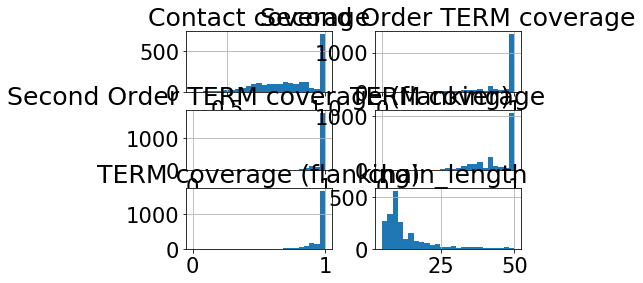

In [310]:
TERM_coverage_2_df.hist(bins=25)

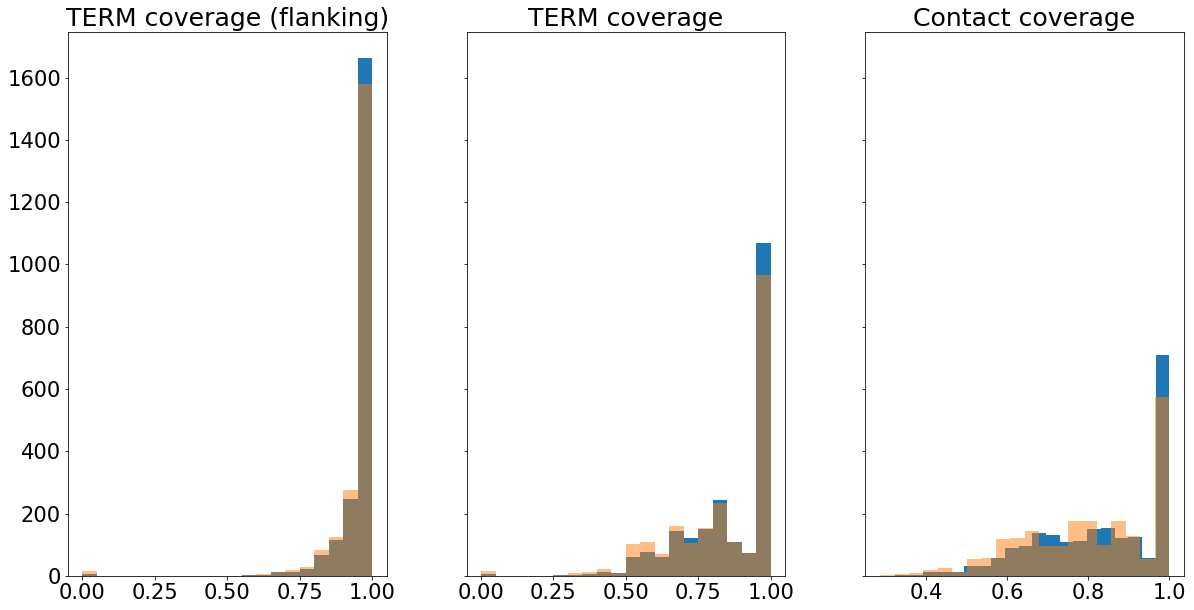

In [214]:
n_bins = 20
plt.rcParams.update({'font.size': 21})
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharey=True,figsize=(20,10))#, tight_layout=True)
ax1.hist(TERM_coverage_2_df["TERM coverage (flanking)"], bins=n_bins)
ax1.hist(TERM_coverage_df["TERM coverage (flanking)"], bins=n_bins,alpha=.5)
ax1.set_title("TERM coverage (flanking)")
ax2.hist(TERM_coverage_2_df["TERM coverage"], bins=n_bins)
ax2.hist(TERM_coverage_df["TERM coverage"], bins=n_bins,alpha=.5)
ax2.set_title("TERM coverage")
ax3.hist(TERM_coverage_2_df["Contact coverage"], bins=n_bins)
ax3.hist(TERM_coverage_df["Contact coverage"], bins=n_bins,alpha=.5)
ax3.set_title("Contact coverage")
fig.subplots_adjust(wspace=.25)


plt.savefig("ss_sb_bb_contacts_histograms.png")

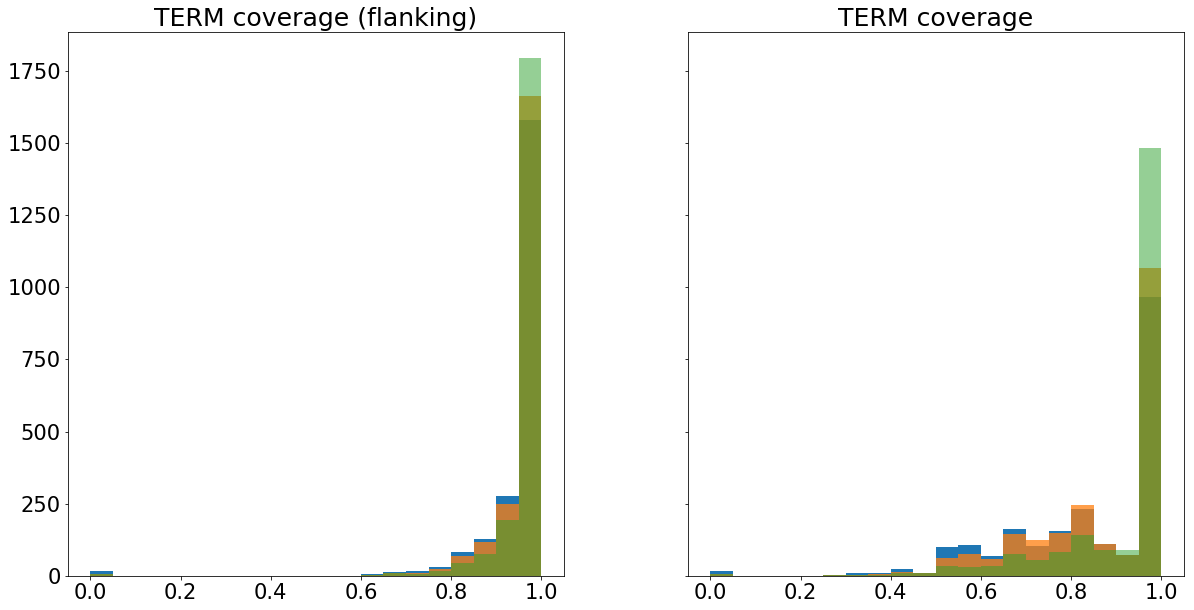

In [321]:
#after adding second order
n_bins = 20
plt.rcParams.update({'font.size': 21})
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True,figsize=(20,10))#, tight_layout=True)
ax1.hist(TERM_coverage_df["TERM coverage (flanking)"], bins=n_bins)
ax1.hist(TERM_coverage_2_df["TERM coverage (flanking)"], bins=n_bins,alpha=.75)
ax1.hist(TERM_coverage_2_df["Second Order TERM coverage (flanking)"], bins=n_bins,alpha=.5)
ax1.set_title("TERM coverage (flanking)")
ax2.hist(TERM_coverage_df["TERM coverage"], bins=n_bins)
ax2.hist(TERM_coverage_2_df["TERM coverage"], bins=n_bins,alpha=.75)
ax2.hist(TERM_coverage_2_df["Second Order TERM coverage"], bins=n_bins,alpha=.5)
ax2.set_title("TERM coverage")
fig.subplots_adjust(wspace=.25)


plt.savefig("second_order_ss_sb_bb_contacts_histograms.png")

In [215]:
TERM_coverage_df.mean()

chain length                13.035382
TERM coverage                0.835847
TERM coverage (flanking)     0.958972
Contact coverage             0.801997
dtype: float64

In [193]:
TERM_coverage_df.median()

chain length                10.000000
TERM coverage                0.875000
TERM coverage (flanking)     1.000000
Contact coverage             0.818182
dtype: float64

In [322]:
TERM_coverage_2_df.mean()

chain_length                             13.035382
TERM coverage                             0.863824
TERM coverage (flanking)                  0.968983
Contact coverage                          0.832029
Second Order TERM coverage                0.921169
Second Order TERM coverage (flanking)     0.977380
dtype: float64

In [323]:
TERM_coverage_2_df.median()

chain_length                             10.000000
TERM coverage                             0.947368
TERM coverage (flanking)                  1.000000
Contact coverage                          0.857143
Second Order TERM coverage                1.000000
Second Order TERM coverage (flanking)     1.000000
dtype: float64

In [41]:
TERM_coverage_2_df.sort_values(['TERM_flanking_coverage'],ascending=True)

,complex,chain_length,TERM_coverage,TERM_flanking_coverage,contact_coverage
757,3FP2_A_Q_191_2,5,0.000000,0.000000,0.600000
396,4JX7_A_B_13_1,5,0.000000,0.000000,0.600000
193,4D0Z_E_Y_114_1,5,0.000000,0.000000,0.800000
680,1EVH_A_B_172_2,5,0.000000,0.000000,0.800000
1564,1GYB_AB_E_417_1,5,0.000000,0.000000,0.400000
1729,4OYK_B_D_480_1,15,0.454545,0.600000,0.466667
1285,4AOQ_C_F_3_1,35,0.451613,0.628571,0.400000
1334,4AOQ_C_F_3_1,35,0.451613,0.628571,0.400000
1471,4TR9_BC_G_387_1,11,0.428571,0.636364,0.636364
1311,1F2S_E_I_3_1,28,0.291667,0.678571,0.392857


In [43]:
TERM_coverage_2_df.sort_values(['contact_coverage'],ascending=True)

,complex,chain_length,TERM_coverage,TERM_flanking_coverage,contact_coverage
1500,2EQ7_AB_C_402_1,37,0.363636,0.729730,0.324324
1191,3C3Q_A_B_311_1,18,0.428571,0.888889,0.388889
1311,1F2S_E_I_3_1,28,0.291667,0.678571,0.392857
1262,1F2S_E_I_3_1,28,0.291667,0.678571,0.392857
1950,1KYD_A_P_74_2,5,1.000000,1.000000,0.400000
1334,4AOQ_C_F_3_1,35,0.451613,0.628571,0.400000
1474,4ROF_B_D_390_1,10,0.500000,0.800000,0.400000
1285,4AOQ_C_F_3_1,35,0.451613,0.628571,0.400000
1564,1GYB_AB_E_417_1,5,0.000000,0.000000,0.400000
1335,4AOR_C_F_3_1,34,0.466667,0.764706,0.411765


In [40]:
#given some pdb
file_path = "/scratch/users/swans/decorate_PixelDB_project/subclusters_fragments_conts_2"
prot_path = "/417/1/1GYB_AB_E_417_1"
total_conts_path = file_path + prot_path + "/prot.conts"
total_pdb_path = file_path + prot_path + "/prot.pdb"
minor_chain = "E"

with open(total_conts_path,"r") as contact_f:
    contact_list = [str.split(line) for line in contact_f if len(re.findall(minor_chain+",",line)) == 1]

contact_df = pd.DataFrame(contact_list,columns=["contact type","main_chain_pos","RES","minor_chain_pos","RES","CD"])

#correct the order of contacts by chain name

for index in contact_df.index:
    if re.search(minor_chain+",",contact_df['minor_chain_pos'][index]) == None:
        contact_df.loc[index,'minor_chain_pos'],contact_df.loc[index,'main_chain_pos'] = contact_df.loc[index,'main_chain_pos'],contact_df.loc[index,'minor_chain_pos']
print(contact_df)

#find the chain length
chain_length = len(importPDB(total_pdb_path,chain_name=minor_chain,data_type='seq'))
chain_length
print('chain length is ',chain_length)
        
#find the list of residues with contacts
res_with_conts = list(set([int(x[2:]) for x in contact_df.iloc[:,3].tolist()]))
print(res_with_conts)

res_count = 0
flanking_list = list()
for i in range(3,chain_length-1):
    if i in res_with_conts:
        res_count += 1
        for j in range(i-2,i+3):
            flanking_list.append(j)
print('ugh',flanking_list)    
flanking_list = list(set(flanking_list))
print('TERM coverage',res_count/(chain_length-4))
print('TERM flanking coverage',len(flanking_list)/(chain_length))
print('contact coverage',len(res_with_conts)/chain_length)
#will add to dictionary

  contact type main_chain_pos  RES minor_chain_pos  RES         CD
0           ss           A,70  GLN             E,2  PHE   0.132299
1           ss           A,74  PRO             E,4  PHE   0.679974
2           ss           B,32  GLU             E,4  PHE   0.143044
3           ss           B,34  MET             E,2  PHE     0.6101
4           ss           B,41  GLN             E,2  PHE  0.0912637
5           ss           B,43  GLN             E,2  PHE   0.175424
6           sb           B,43  GLN             E,2  PHE  0.0601625
chain length is  5
[2, 4]
ugh []
TERM coverage 0.0
TERM flanking coverage 0.0
contact coverage 0.4


# End Contact Analysis

In [224]:
TERM_coverage_2_df

,complex,chain_length,TERM coverage,TERM coverage (flanking),Contact coverage,Contacts per residue
0,1OU8_A_C_100_1,11,0.857143,0.909091,0.727273,"[0, 0, 0, 1, 6, 5, 4, 4, 4, 1, 8]"
1,1TWB_A_C_100_1,8,1.000000,1.000000,1.000000,"[6, 6, 6, 4, 4, 1, 8, 1]"
2,1YFN_C_G_100_2,15,0.727273,1.000000,0.733333,"[3, 2, 6, 2, 1, 3, 0, 0, 3, 1, 0, 4, 3, 8, 0]"
3,4IKN_A_B_101_3,5,1.000000,1.000000,1.000000,"[2, 5, 2, 1, 7]"
4,1CA0_GH_F_10_1,11,1.000000,1.000000,0.909091,"[7, 7, 1, 4, 3, 6, 2, 7, 1, 2, 0]"
5,1CHO_FG_E_10_1,10,1.000000,1.000000,1.000000,"[6, 5, 1, 4, 2, 7, 1, 6, 1, 3]"
6,1YPH_DF_B_10_1,12,1.000000,1.000000,1.000000,"[6, 5, 2, 4, 2, 8, 1, 7, 1, 2, 1, 3]"
7,3L81_A_B_101_1,7,1.000000,1.000000,0.857143,"[1, 3, 3, 4, 4, 1, 0]"
8,2CHA_FG_E_10_1,8,1.000000,1.000000,0.875000,"[5, 6, 1, 4, 1, 6, 0, 6]"
9,1I31_A_P_101_2,6,0.500000,0.833333,0.666667,"[1, 5, 2, 0, 8, 0]"


In [256]:
mean_contacts = list()
mean_end_contacts = list()
mean_end2_contacts = list()
end_contacts_n = list()
end_contacts_c = list()
for i in TERM_coverage_2_df["Contacts per residue"]:
    mean_contacts.append(np.mean(i))
    mean_end_contacts.append(np.mean([i[0],i[-1]]))
    mean_end2_contacts.append(np.mean([i[:2]+i[-2:]]))
    end_contacts_n.append(i[0])
    end_contacts_c.append(i[-1])
TERM_coverage_2_df['Mean contacts'] = mean_contacts
TERM_coverage_2_df['Mean end contacts'] = mean_end_contacts
TERM_coverage_2_df['Mean end contacts (2)'] = mean_end2_contacts
TERM_coverage_2_df['End contacts (N)'] = end_contacts_n
TERM_coverage_2_df['End contacts (C)'] = end_contacts_c
TERM_coverage_2_df

,complex,chain_length,TERM coverage,TERM coverage (flanking),Contact coverage,Contacts per residue,Mean contacts,Mean end contacts,Mean end contacts (2),End contacts (N),End contacts (C)
0,1OU8_A_C_100_1,11,0.857143,0.909091,0.727273,"[0, 0, 0, 1, 6, 5, 4, 4, 4, 1, 8]",3.000000,4.0,2.25,0,8
1,1TWB_A_C_100_1,8,1.000000,1.000000,1.000000,"[6, 6, 6, 4, 4, 1, 8, 1]",4.500000,3.5,5.25,6,1
2,1YFN_C_G_100_2,15,0.727273,1.000000,0.733333,"[3, 2, 6, 2, 1, 3, 0, 0, 3, 1, 0, 4, 3, 8, 0]",2.400000,1.5,3.25,3,0
3,4IKN_A_B_101_3,5,1.000000,1.000000,1.000000,"[2, 5, 2, 1, 7]",3.400000,4.5,3.75,2,7
4,1CA0_GH_F_10_1,11,1.000000,1.000000,0.909091,"[7, 7, 1, 4, 3, 6, 2, 7, 1, 2, 0]",3.636364,3.5,4.00,7,0
5,1CHO_FG_E_10_1,10,1.000000,1.000000,1.000000,"[6, 5, 1, 4, 2, 7, 1, 6, 1, 3]",3.600000,4.5,3.75,6,3
6,1YPH_DF_B_10_1,12,1.000000,1.000000,1.000000,"[6, 5, 2, 4, 2, 8, 1, 7, 1, 2, 1, 3]",3.500000,4.5,3.75,6,3
7,3L81_A_B_101_1,7,1.000000,1.000000,0.857143,"[1, 3, 3, 4, 4, 1, 0]",2.285714,0.5,1.25,1,0
8,2CHA_FG_E_10_1,8,1.000000,1.000000,0.875000,"[5, 6, 1, 4, 1, 6, 0, 6]",3.625000,5.5,4.25,5,6
9,1I31_A_P_101_2,6,0.500000,0.833333,0.666667,"[1, 5, 2, 0, 8, 0]",2.666667,0.5,3.50,1,0


In [250]:
i[1]

3

In [257]:
TERM_coverage_2_df.mean()

chain_length                13.035382
TERM coverage                0.863824
TERM coverage (flanking)     0.968983
Contact coverage             0.832029
Mean contacts                3.638292
Mean end contacts            3.208799
Mean end contacts (2)        3.330889
End contacts (N)             2.700186
End contacts (C)             3.717412
dtype: float64

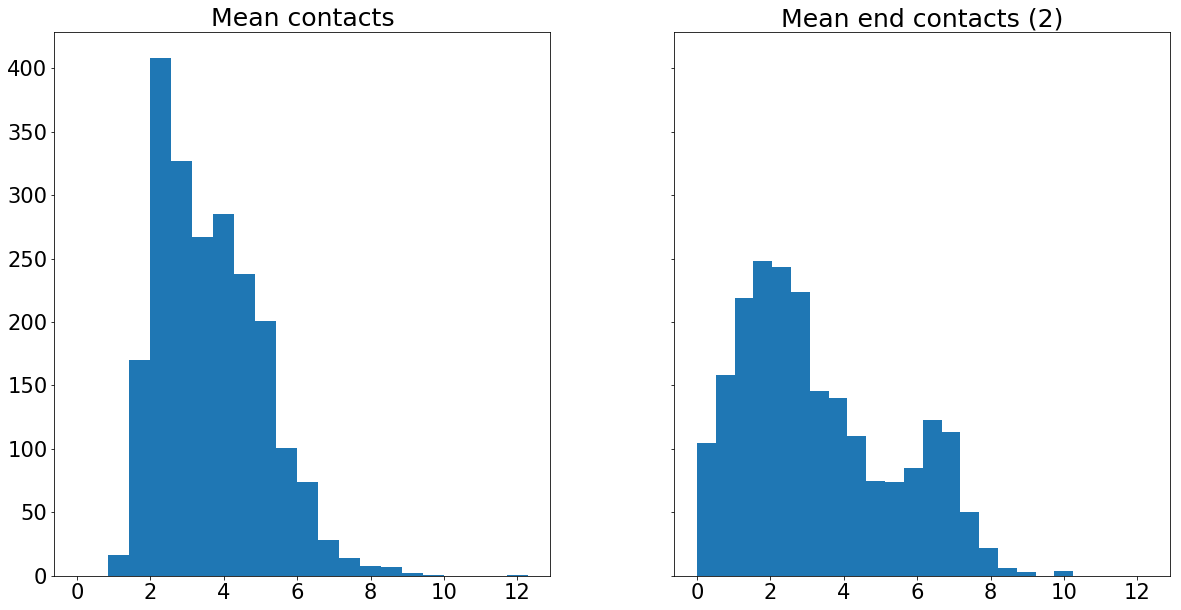

In [262]:
# contact comparison
n_bins = 20
plt.rcParams.update({'font.size': 21})
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True,sharex=True,figsize=(20,10))#, tight_layout=True)
ax1.hist(TERM_coverage_2_df["Mean contacts"], bins=n_bins)
ax1.set_title("Mean contacts")
ax2.hist(TERM_coverage_2_df["Mean end contacts (2)"], bins=n_bins)
ax2.set_title("Mean end contacts (2)")
fig.subplots_adjust(wspace=.25)


plt.savefig("mean_contacts_histograms.png")

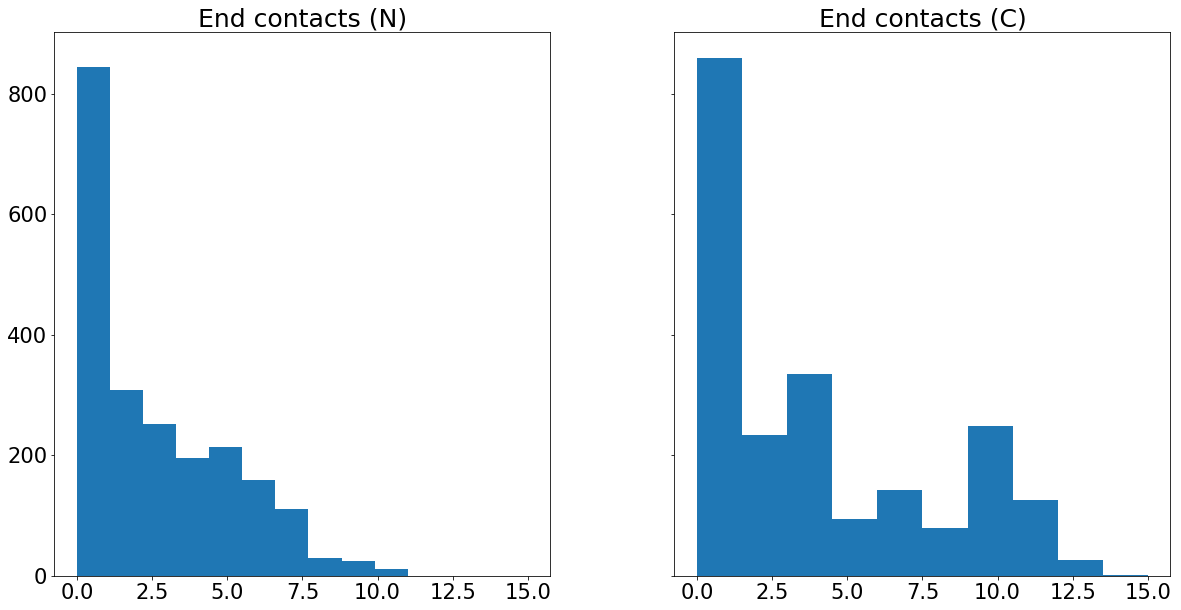

In [261]:
# contact comparison
n_bins = 10
plt.rcParams.update({'font.size': 21})
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True,sharex=True,figsize=(20,10))#, tight_layout=True)
ax1.hist(TERM_coverage_2_df["End contacts (N)"], bins=n_bins)
ax1.set_title("End contacts (N)")
ax2.hist(TERM_coverage_2_df["End contacts (C)"], bins=n_bins)
ax2.set_title("End contacts (C)")
fig.subplots_adjust(wspace=.25)


plt.savefig("mean_contacts_histograms.png")

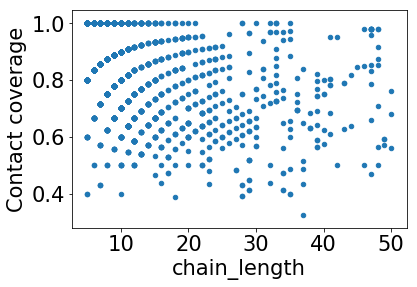

In [264]:
TERM_coverage_2_df.plot.scatter(x='chain_length',y='Contact coverage')

In [326]:
corr_df = TERM_coverage_2_df[["chain_length","TERM coverage","TERM coverage (flanking)","Second Order TERM coverage (flanking)","Second Order TERM coverage","Contact coverage"]].corr(method='spearman')
corr_df

,chain_length,TERM coverage,TERM coverage (flanking),Second Order TERM coverage (flanking),Second Order TERM coverage,Contact coverage
chain_length,1.000000,-0.530631,-0.317142,-0.245760,-0.395707,-0.439968
TERM coverage,-0.530631,1.000000,0.657908,0.531749,0.728394,0.810798
TERM coverage (flanking),-0.317142,0.657908,1.000000,0.820145,0.588971,0.543856
Second Order TERM coverage (flanking),-0.245760,0.531749,0.820145,1.000000,0.709715,0.455612
Second Order TERM coverage,-0.395707,0.728394,0.588971,0.709715,1.000000,0.612402
Contact coverage,-0.439968,0.810798,0.543856,0.455612,0.612402,1.000000


In [334]:
corr_df["chain_length"]

chain_length                             1.000000
TERM coverage                           -0.530631
TERM coverage (flanking)                -0.317142
Second Order TERM coverage (flanking)   -0.245760
Second Order TERM coverage              -0.395707
Contact coverage                        -0.439968
Name: chain_length, dtype: float64

In [335]:
import seaborn as sns

sns.heatmap(corr_df["chain_length"],vmin=-.5,vmax=1)
plt.savefig("corr_df.png")

IndexError: Inconsistent shape between the condition and the input (got (6, 1) and (6,))